# Cyclistic Bike-Share 🚴‍♀️📊

## Case study: How does a bike-share navigate speedy success?

### Table of Contents
1. 



## Introduction 

### Objective 

Explore how different customer types—casual riders and annual members—use the Cyclistic bike-share system in Chicago. The marketing team aims to increase annual memberships, so understanding these user behaviors is crucial. 

This EDA will investigate ride patterns, usage frequency, ride durations, and temporal trends (e.g., day of week, time of day) across both groups. 

Insights drawn from this analysis will inform strategic recommendations to help convert casual riders into annual members. Findings will be supported by clear, professional visualizations to guide executive decision-making.

## Data Preparation

### Setup and Data Source

Import the necessary libraries for analysis:

In [1]:
# Import essential libraries
import os
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, Generator
from urllib.parse import urlparse
from IPython.display import display, Image, Markdown

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")


Set up our directory structure and data sources:

#### Data Source: 

Cyclistic's historical trip data is hosted through following s3 URL (https://divvy-tripdata.s3.amazonaws.com/index.html) provided by the Google Data Analytics Capstone course.

Each month's trip data is listed as a unique zip file containing a CSV. 
This analysis focuses on the last 12 months of historical trip data: November 2023 - October 2024. 

In [2]:
# Data source ZIP URLs for data range (November 2023 - October 2024)

RAW_DATA_DIR = [
    "https://divvy-tripdata.s3.amazonaws.com/202311-divvy-tripdata.zip",
    "https://divvy-tripdata.s3.amazonaws.com/202312-divvy-tripdata.zip",
    "https://divvy-tripdata.s3.amazonaws.com/202401-divvy-tripdata.zip",
    "https://divvy-tripdata.s3.amazonaws.com/202402-divvy-tripdata.zip",
    "https://divvy-tripdata.s3.amazonaws.com/202403-divvy-tripdata.zip",
    "https://divvy-tripdata.s3.amazonaws.com/202404-divvy-tripdata.zip",
    "https://divvy-tripdata.s3.amazonaws.com/202405-divvy-tripdata.zip",
    "https://divvy-tripdata.s3.amazonaws.com/202406-divvy-tripdata.zip",
    "https://divvy-tripdata.s3.amazonaws.com/202407-divvy-tripdata.zip",
    "https://divvy-tripdata.s3.amazonaws.com/202408-divvy-tripdata.zip",
    "https://divvy-tripdata.s3.amazonaws.com/202409-divvy-tripdata.zip",
    "https://divvy-tripdata.s3.amazonaws.com/202410-divvy-tripdata.zip"
]

### Data Loading and Initial Exploration

Define a function that downloads and processes a ZIP file containing CSV data:

- Extracts the ZIP contents in memory (without saving to disk)
- Finds the first CSV file in the ZIP archive
- Reads the CSV directly into a pandas DataFrame

In [3]:
def download_and_extract(url: str) -> pd.DataFrame:
    """
    Download and extract a zip file from S3 URL.
    """
    try:
        # Download the zip file
        response = requests.get(url)
        response.raise_for_status()
        
        # Extract the zip file in memory
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Get the CSV file name (assuming one CSV per zip)
            csv_file = [f for f in zip_ref.namelist() if f.endswith('.csv')][0]
            
            # Read the CSV directly from the zip file
            with zip_ref.open(csv_file) as csv_file:
                return pd.read_csv(csv_file)
    except Exception as e:
        raise Exception(f"Error downloading/extracting {url}: {str(e)}")

Define a function to manage the data integration workflow: 

- Accepts a list of URLs and returns both a pandas DataFrame and statistics dictionary tracking intial integration statistics including:
- Uses a generator function (read_s3_files) to efficiently process files one at a time
- Finally combines all DataFrames and documents the final data structure before returning results

In [4]:
def integrate_data(urls: list) -> Tuple[pd.DataFrame, Dict]:
    """
    Integrate multiple CSV files from S3 URLs into a single dataset.
    """
    integration_stats = {
        "files_processed": 0,
        "total_records": 0,
        "files_with_errors": [],
        "data_structure": {
            "columns": [],
            "data_types": {},
            "unique_identifiers": [],
            "missing_values": {},
        },
    }

    def read_s3_files() -> Generator[pd.DataFrame, None, None]:
        """Generator function to read files from S3 one at a time."""
        if not urls:
            raise ValueError("No URLs provided in RAW_DATA_DIR")

        for url in urls:
            try:
                # Extract filename from URL for error reporting
                filename = os.path.basename(urlparse(url).path)
                trip_data = download_and_extract(url)
                integration_stats["files_processed"] += 1
                integration_stats["total_records"] += len(trip_data)
                yield trip_data
            except Exception as e:
                integration_stats["files_with_errors"].append(filename)
                print(f"Error processing {filename}: {str(e)}")

    try:
        # Use generator to read and concatenate files
        merged_data = pd.concat(read_s3_files(), ignore_index=True)

        # Document initial data structure
        integration_stats["data_structure"] = {
            "columns": list(merged_data.columns),
            "data_types": {
                col: str(dtype) for col, dtype in merged_data.dtypes.items()
            },
            "unique_identifiers": ["ride_id"],
            "missing_values": merged_data.isnull().sum().to_dict(),
            "total_records": len(merged_data),
        }
        return merged_data, integration_stats

    except Exception as e:
        raise Exception(f"Error in integrate_data: {str(e)}") from e

In [6]:
# Load 12 months of data
sample_urls = RAW_DATA_DIR[:]  
print(f"Loading data from {len(sample_urls)} months...")

raw_data, integration_stats = integrate_data(sample_urls)

Loading data from 12 months...


Overview of data structure from integration:  

In [7]:
# integration_stats

View column and data types: 

In [8]:
# Data types and missing values
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5933712 entries, 0 to 5933711
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 588.5+ MB


View first few rows: 

In [9]:
# First 5 rows of the dataset
raw_data.head()

ride_id  rideable_type           started_at             ended_at  \
0  4EAD8F1AD547356B  electric_bike  2023-11-30 21:50:05  2023-11-30 22:13:27   
1  6322270563BF5470  electric_bike  2023-11-03 09:44:02  2023-11-03 10:17:15   
2  B37BDE091ECA38E0  electric_bike  2023-11-30 11:39:44  2023-11-30 11:40:08   
3  CF0CA5DD26E4F90E   classic_bike  2023-11-08 10:01:45  2023-11-08 10:27:05   
4  EB8381AA641348DB   classic_bike  2023-11-03 16:20:25  2023-11-03 16:54:25   

       start_station_name start_station_id               end_station_name  \
0         Millennium Park            13008  Pine Grove Ave & Waveland Ave   
1  Broadway & Sheridan Rd            13323         Broadway & Sheridan Rd   
2   State St & Pearson St     TA1307000061          State St & Pearson St   
3     Theater on the Lake     TA1308000001            Theater on the Lake   
4     Theater on the Lake     TA1308000001            Theater on the Lake   

  end_station_id  start_lat  start_lng    end_lat    end_lng member_casual  
0   TA1307000150  41.881101 -87.624082  41.949473 -87.646453        member  
1          13323  41.952868 -87.650035  41.952833 -87.649993        member  
2   TA1307000061  41.897533 -87.628694  41.897448 -87.628722        member  
3   TA1308000001  41.926277 -87.630834  41.926277 -87.630834        member  
4   TA1308000001  41.926277 -87.630834  41.926277 -87.630834        member

 "ride_id",
    "rideable_type",
    "started_at",
    "ended_at",
    "start_station_name",
    "end_station_name",
    "start_lat",
    "start_lng",
    "end_lat",
    "end_lng",
    "member_casual"

Visualize missing values to better undestand their distribution. 

In [10]:
# Calculate missing values percentage
missing_values = raw_data.isnull().sum()
missing_percentage = (missing_values / len(raw_data)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values, 
    'Percentage': missing_percentage
}).sort_values('Percentage', ascending=False)

# Filter to show only columns with missing values
missing_df = missing_df[missing_df['Missing Values'] > 0]
missing_df

Missing Values  Percentage
end_station_name           1112056   18.741321
end_station_id             1112056   18.741321
start_station_name         1079270   18.188783
start_station_id           1079270   18.188783
end_lat                       7417    0.124998
end_lng                       7417    0.124998

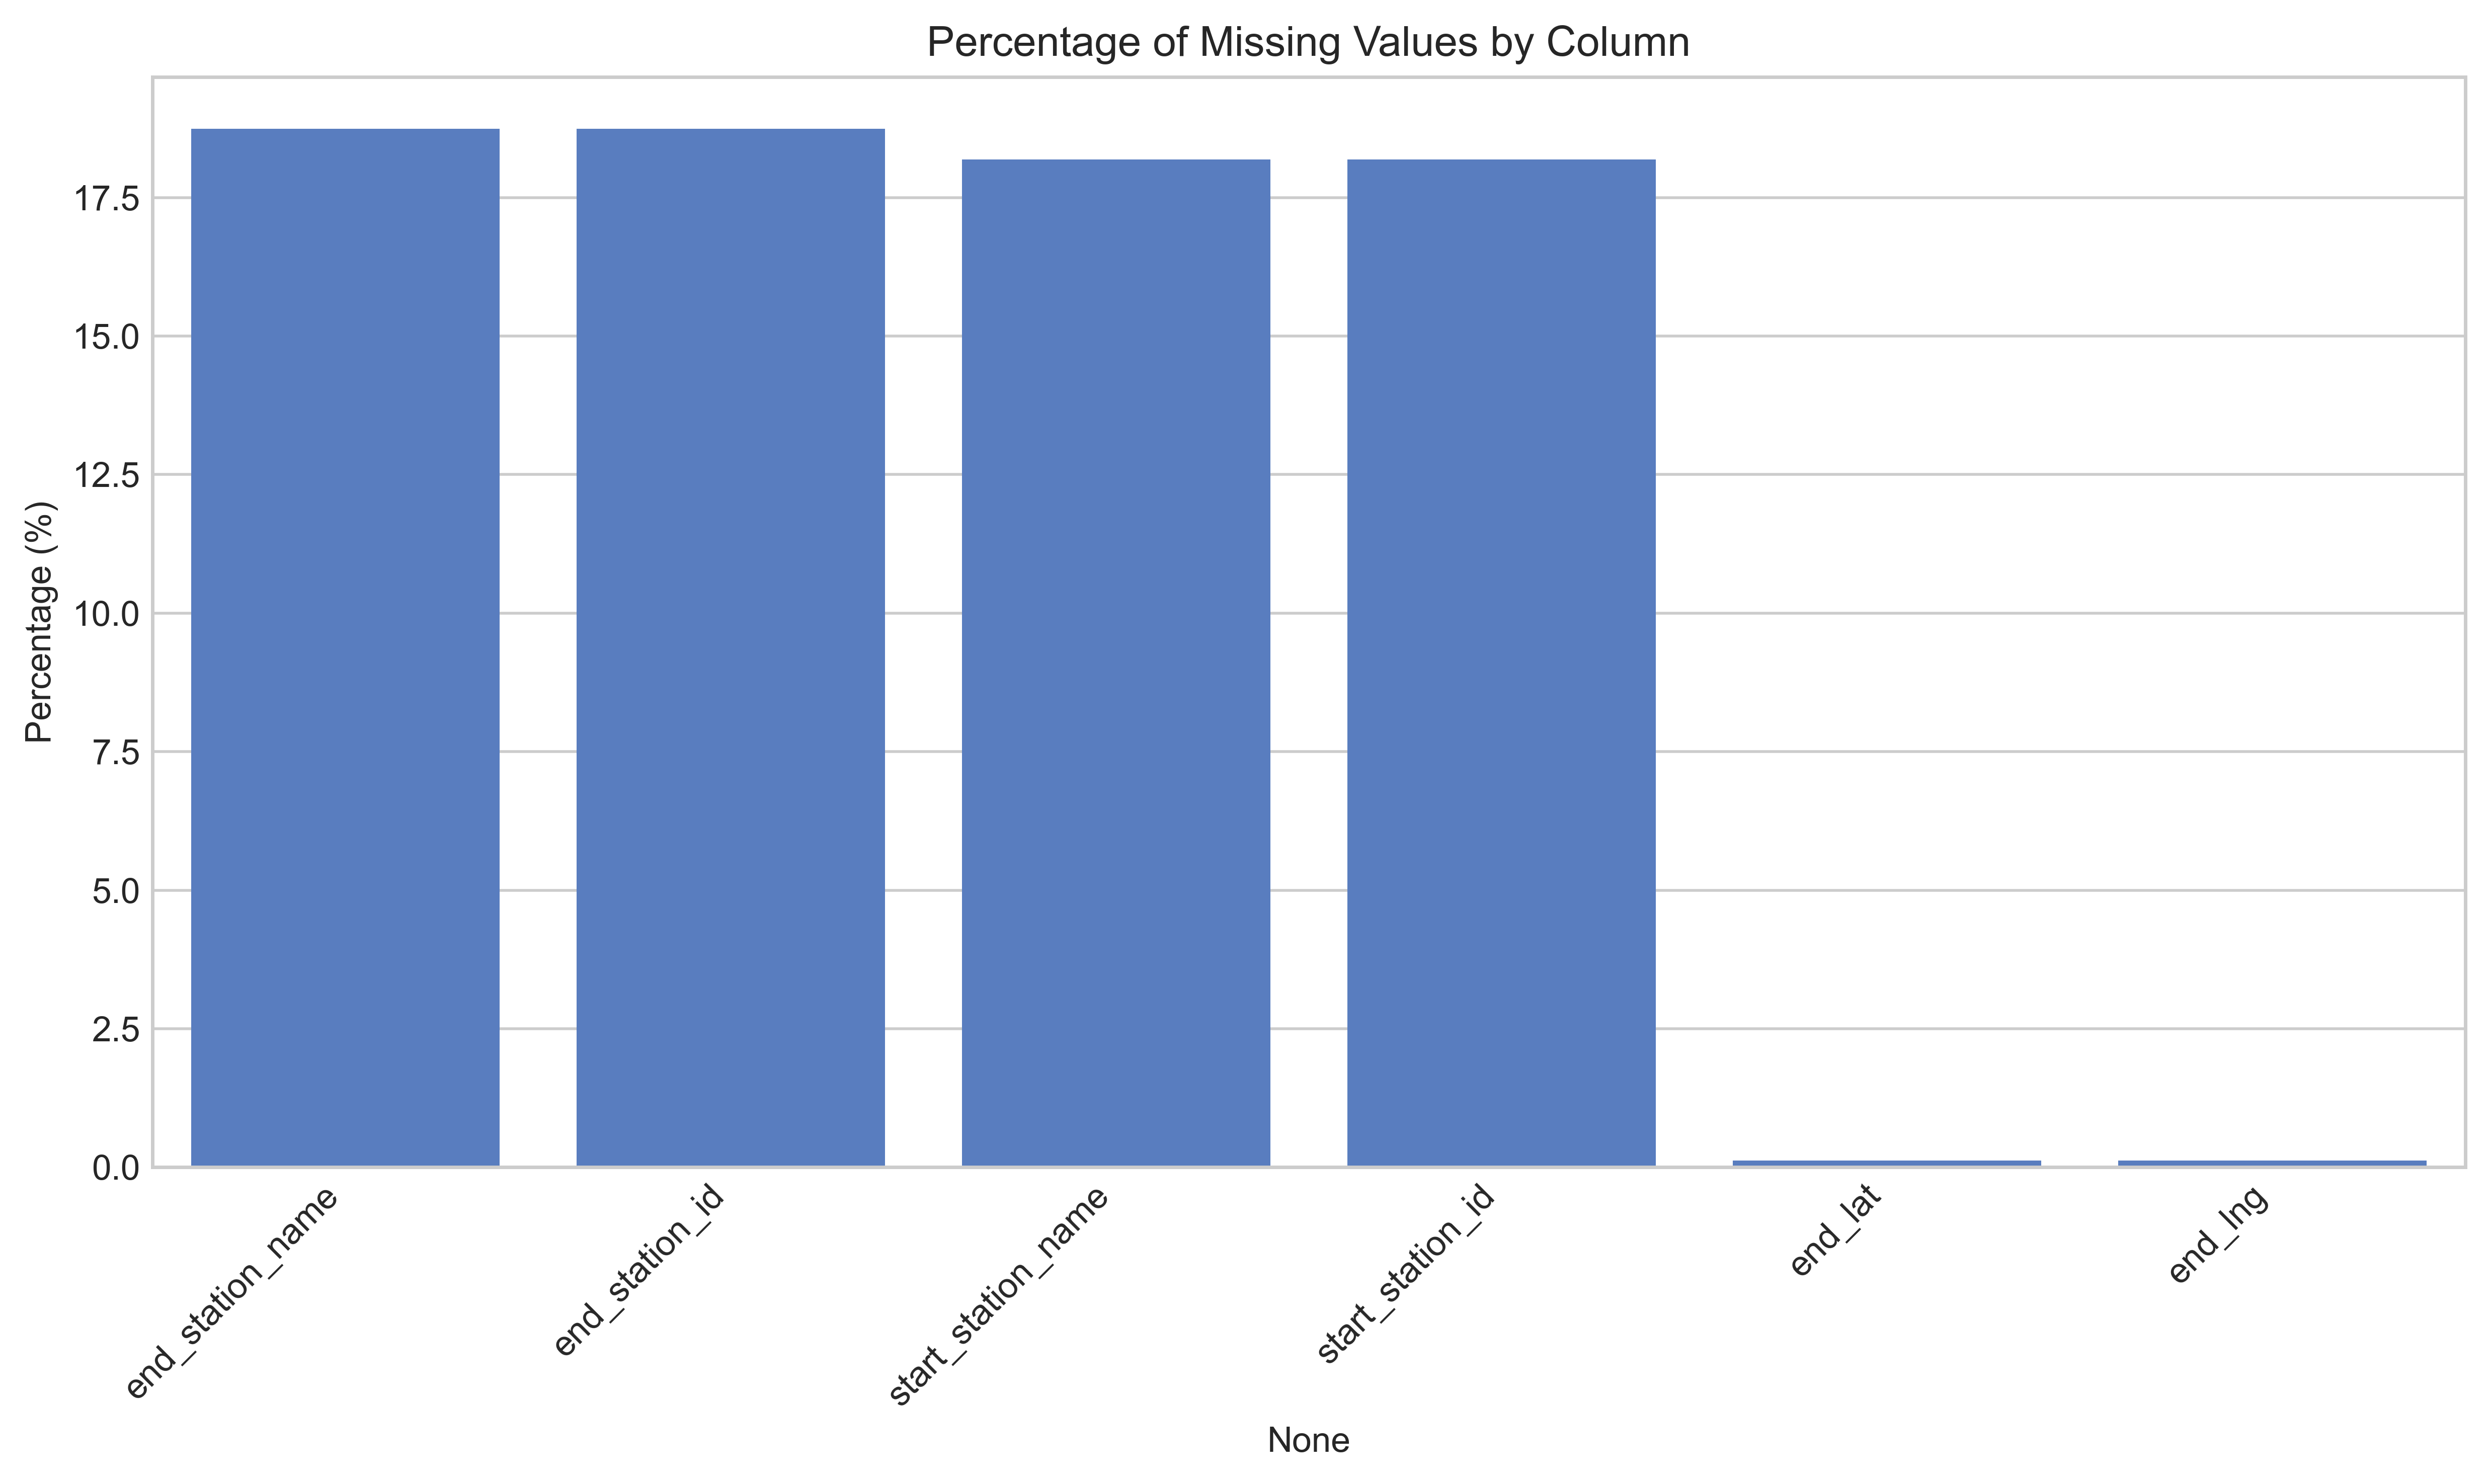

In [11]:
plt.figure(figsize=(10, 6), dpi=500)
sns.barplot(x=missing_df.index, y='Percentage', data=missing_df)
plt.title('Percentage of Missing Values by Column')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage (%)')
plt.tight_layout()
plt.show()

Close to 20% of the dataset lacks location based data. 

Explore distribution of some categorical variables:

In [12]:
# Set temporal dictionaries to map datetime objects as meaningful categories. 
DAY_MAPPING = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}

MONTH_MAPPING = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December",
}

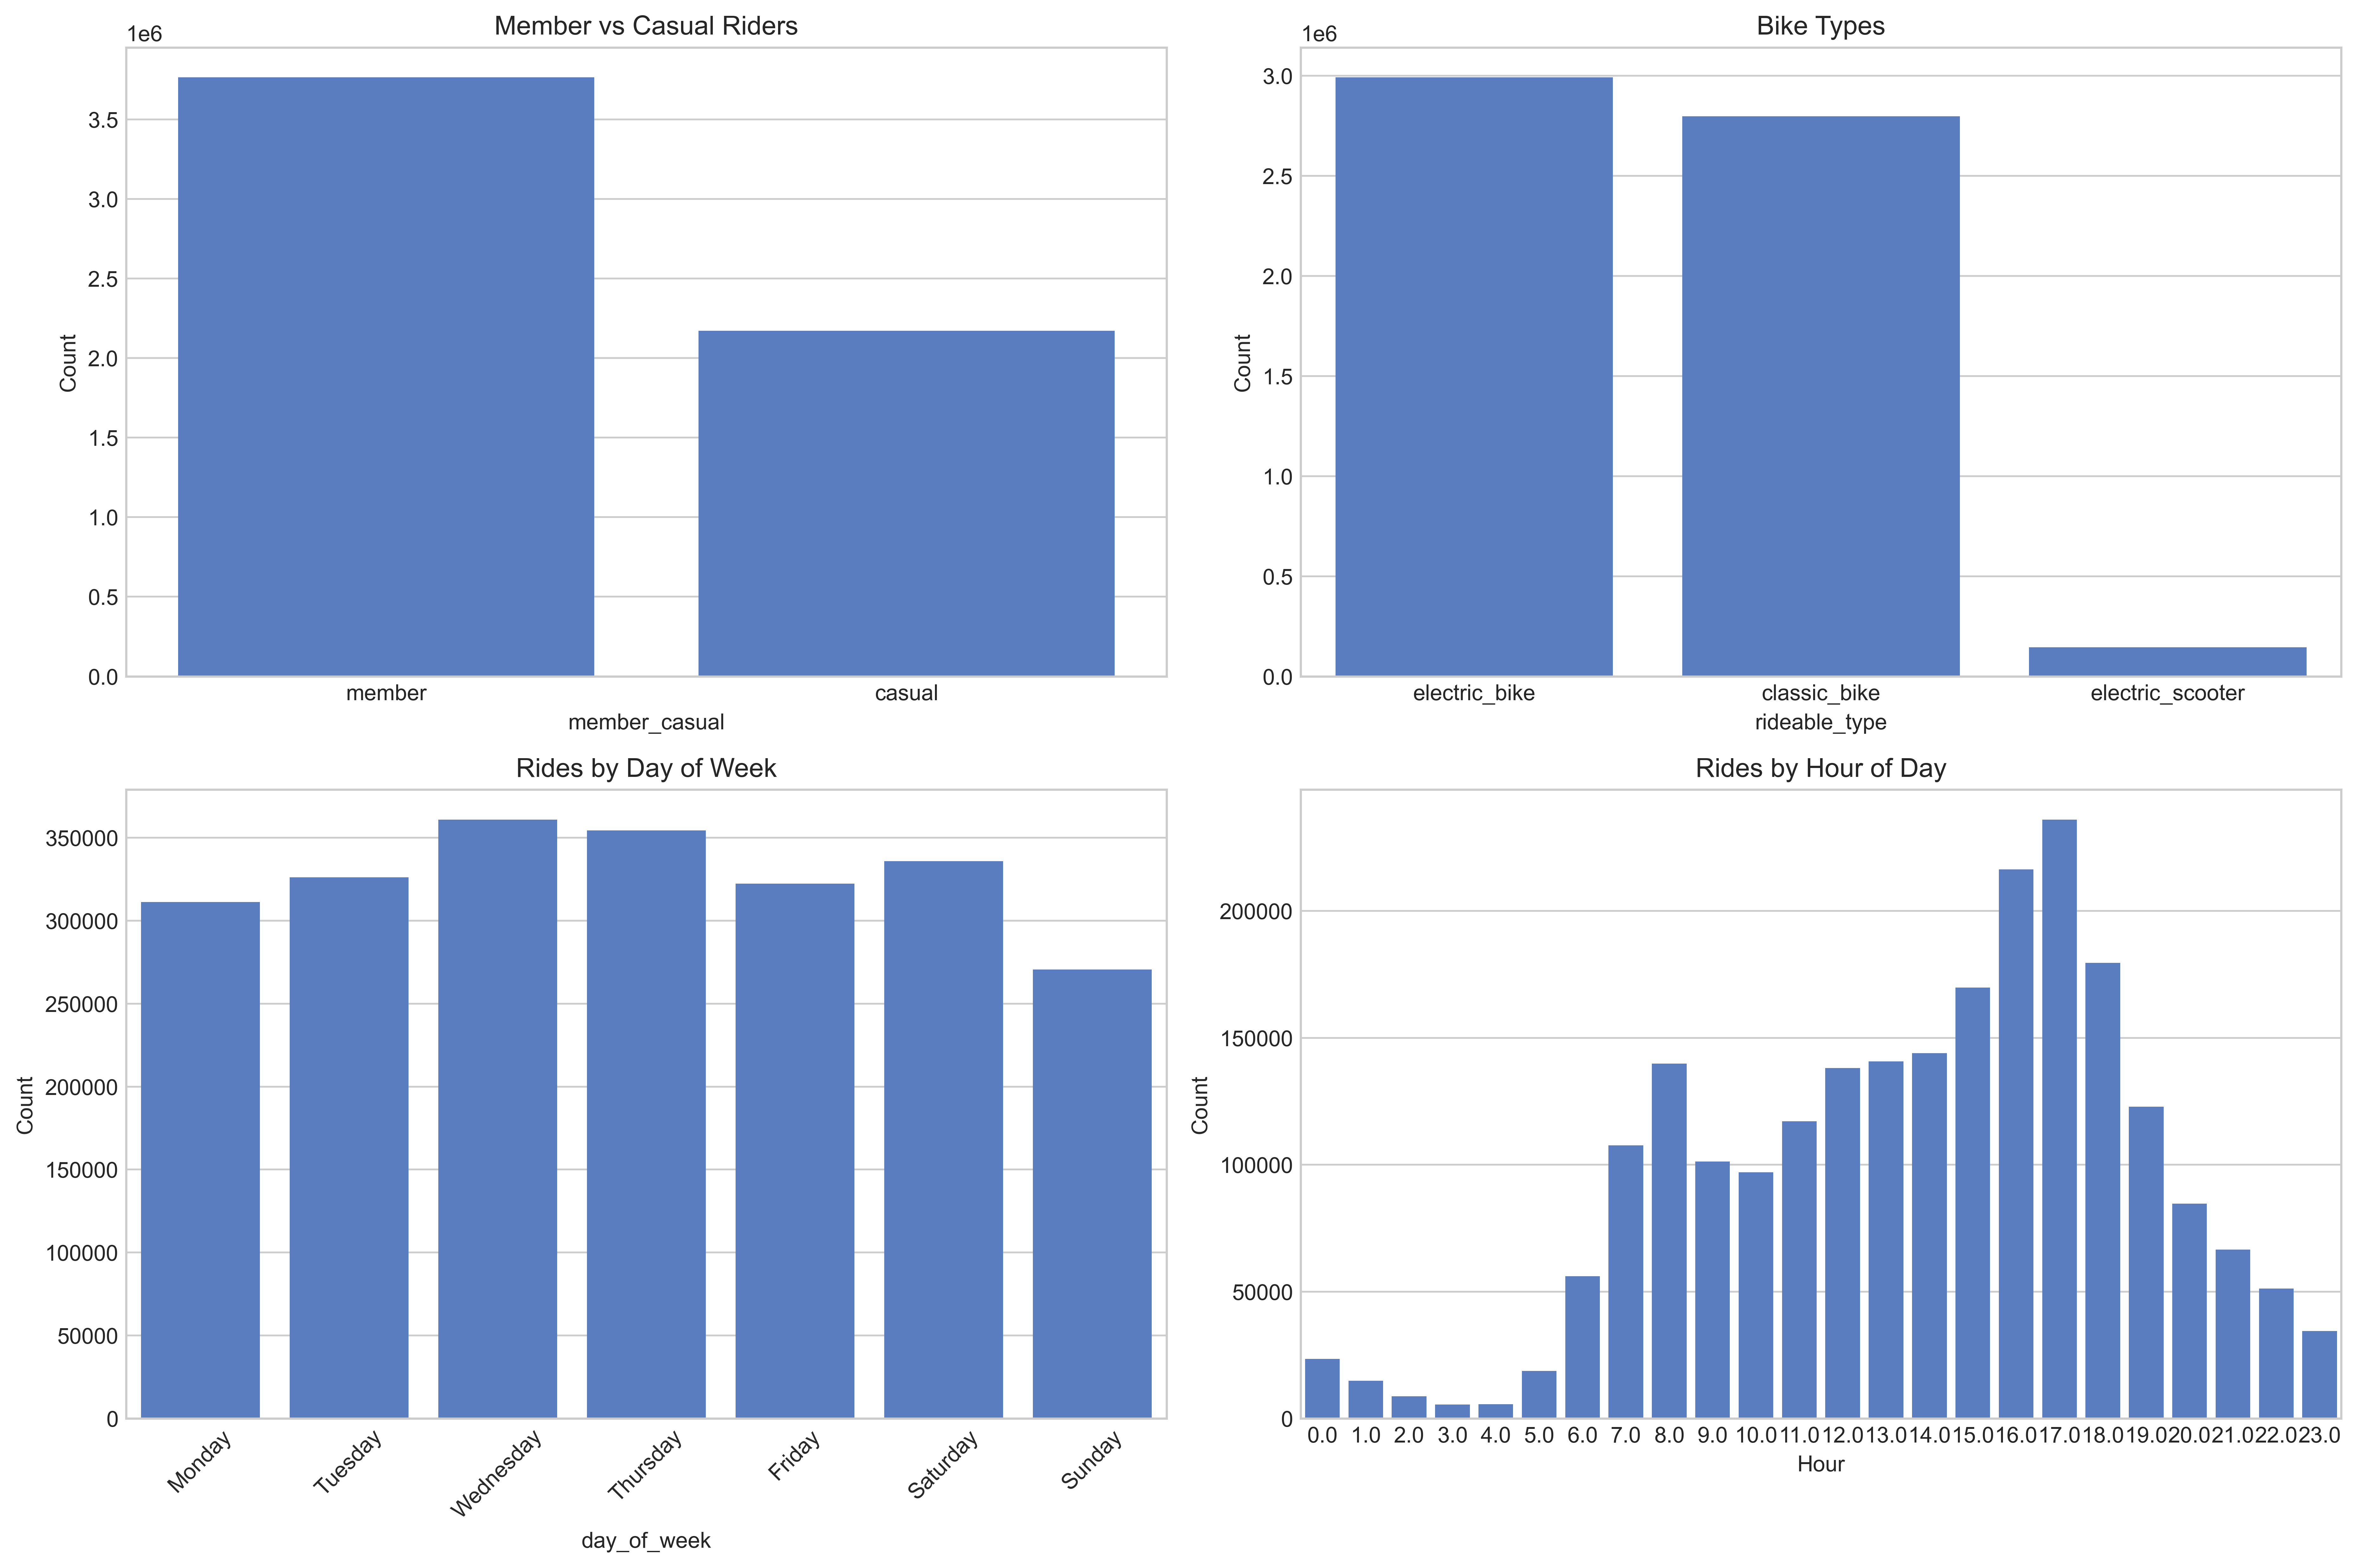

In [13]:
plt.figure(figsize=(15, 10), dpi=500)

# Plot 1: Distribution of member types
plt.subplot(2, 2, 1)
member_counts = raw_data['member_casual'].value_counts()
sns.barplot(x=member_counts.index, y=member_counts.values)
plt.title('Member vs Casual Riders')
plt.ylabel('Count')

# Plot 2: Distribution of bike types
plt.subplot(2, 2, 2)
bike_counts = raw_data['rideable_type'].value_counts()
sns.barplot(x=bike_counts.index, y=bike_counts.values)
plt.title('Bike Types')
plt.ylabel('Count')

# Convert datetime for the remaining plots
raw_data['temp_started_at'] = pd.to_datetime(raw_data['started_at'], errors='coerce')

# Plot 3: Rides by day of week
plt.subplot(2, 2, 3)
raw_data['day_of_week'] = raw_data['temp_started_at'].dt.day_of_week
day_counts = raw_data['day_of_week'].map(DAY_MAPPING).value_counts().reindex(DAY_MAPPING.values())
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title('Rides by Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot 4: Rides by hour of day
plt.subplot(2, 2, 4)
raw_data['hour'] = raw_data['temp_started_at'].dt.hour
hour_counts = raw_data['hour'].value_counts().sort_index()
sns.barplot(x=hour_counts.index, y=hour_counts.values)
plt.title('Rides by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Clean up temporary columns
raw_data.drop(['temp_started_at', 'day_of_week', 'hour'], axis=1, errors='ignore', inplace=True)

### Data Cleaning

In [14]:
# make a copy of raw data
df = raw_data.copy()
print(f"Original shape: {df.shape}")

Original shape: (5933712, 13)


#### Handling Duplicate Ride IDs

Ride_id field should uniquely identify each ride instance, guranteeing entity integrity.

Check for null and duplicate ride IDs:

In [15]:
# Check for null ride IDs 
null_ride_ids = df['ride_id'].isnull().sum()
print(f"Found {null_ride_ids:,} null ride IDs ({null_ride_ids/len(df):.2%} of data)")

# Check for duplicate ride IDs
duplicate_ride_ids = df.duplicated(subset=["ride_id"]).sum()
print(f"Found {duplicate_ride_ids:,} duplicate ride IDs ({duplicate_ride_ids/len(df):.4%} of data)")

Found 0 null ride IDs (0.00% of data)
Found 211 duplicate ride IDs (0.0036% of data)


**Explore duplicate ride IDs:**

Count how many times each ID appears and filter for duplicates:

In [16]:
duplicate_counts = df.groupby('ride_id').size().reset_index(name='count')
duplicate_counts = duplicate_counts[duplicate_counts['count'] > 1]
print(f"Duplicate ride_id counts:\n{duplicate_counts}")

Duplicate ride_id counts:
                  ride_id  count
25601    011C8EF97AB0F30D      2
28817    01406457A85B0AFF      2
54983    02606FBC7F8537EE      2
77133    0354FD0756337B59      2
105168   048C715F1DE0D8C0      2
...                   ...    ...
5762623  F8A9257D1DD04F43      2
5794089  FA03ED5FBCE6E570      2
5855824  FCA692A3455D0366      2
5856351  FCAC6F8E18670115      2
5901427  FEA150E7A56F187E      2

[211 rows x 2 columns]


It appears affected IDs are only duplicates of two. 

Verify: 

In [17]:
# Check for more than two duplicates
duplicate_counts_over_two = duplicate_counts[duplicate_counts['count'] > 2]
print(f"Duplicate ride_id counts over two:\n{duplicate_counts_over_two}")

Duplicate ride_id counts over two:
Empty DataFrame
Columns: [ride_id, count]
Index: []


Spot check a few duplicate rides:

In [18]:
# View three pairs of duplicate ride IDs 
sample_duplicates = duplicate_counts['ride_id'].values[:3]
sample_check = df[df['ride_id'].isin(sample_duplicates)].sort_values(by="ride_id")
sample_check

ride_id  rideable_type               started_at  \
1943417  011C8EF97AB0F30D   classic_bike      2024-05-31 19:45:38   
2746681  011C8EF97AB0F30D   classic_bike  2024-05-31 19:45:38.037   
1775236  01406457A85B0AFF  electric_bike      2024-05-31 23:54:59   
2563014  01406457A85B0AFF  electric_bike  2024-05-31 23:54:59.194   
1943749  02606FBC7F8537EE   classic_bike      2024-05-31 17:55:01   
2742401  02606FBC7F8537EE   classic_bike  2024-05-31 17:55:01.635   

                        ended_at             start_station_name  \
1943417      2024-06-01 20:45:33     Clifton Ave & Armitage Ave   
2746681  2024-06-01 20:45:33.862     Clifton Ave & Armitage Ave   
1775236      2024-06-01 00:01:47                            NaN   
2563014  2024-06-01 00:01:47.626                            NaN   
1943749      2024-06-01 18:54:53  Pine Grove Ave & Waveland Ave   
2742401  2024-06-01 18:54:53.970  Pine Grove Ave & Waveland Ave   

        start_station_id         end_station_name end_station_id  start_lat  \
1943417     TA1307000163                      NaN            NaN  41.918216   
2746681     TA1307000163                      NaN            NaN  41.918216   
1775236              NaN  Damen Ave & Chicago Ave          13132  41.890000   
2563014              NaN  Damen Ave & Chicago Ave          13132  41.890000   
1943749     TA1307000150                      NaN            NaN  41.949473   
2742401     TA1307000150                      NaN            NaN  41.949473   

         start_lng    end_lat   end_lng member_casual  
1943417 -87.656936        NaN       NaN        casual  
2746681 -87.656936        NaN       NaN        casual  
1775236 -87.670000  41.895769 -87.67722        member  
2563014 -87.670000  41.895769 -87.67722        member  
1943749 -87.646453        NaN       NaN        casual  
2742401 -87.646453        NaN       NaN        casual

These duplicate rides have identical values in each field except the timestamps.
Columns `started_at` and `ended_at` in the duplicate records are formatted differently:

- One record has millisecond precision (e.g., **2024-05-31 19:45:38.037**).
- The other does not have millisecond precision (e.g., **2024-05-31 19:45:38**).

Duplicates are likely caused by data formatting inconsistencies rather than actual duplicate rides. 

Following the data trend, the precise millisecond version is the duplicate. 

Furthermore the data inconsistency only occurs on one specific day within the entire set: may 31st, 2024. 

Verify by isolating the month of affected IDs. 

In [19]:
# Filter duplicate records
duplicate_records = df[df.duplicated(subset=["ride_id"], keep=False)].copy()

# Extract the days from the started_at column (excluding time)
duplicate_records["started_at_date"] = pd.to_datetime(
    duplicate_records["started_at"], format="mixed", dayfirst=False, errors="coerce"
).dt.date

# Count the number of duplicates per day
duplicates_per_day = duplicate_records["started_at_date"].value_counts().sort_index()
print("Duplicates per day:")
print(duplicates_per_day)


Duplicates per day:
started_at_date
2024-05-31    422
Name: count, dtype: int64


All 211 duplicate ride ID errors were recorded on May 31st, 2024. 

**Note Issue:**
- Issue #1: 211 Ride IDs on 05/31/24 are duplicated once in the dataset. 
- Column: Ride_id
- Affected Rows: 422 
- Resolution: Keep first instance of unique ride ID entry.  

Address issue by keeping the last instance of each duplicate record. 

In [20]:
# Remove duplicates
df.drop_duplicates(subset=["ride_id"], keep="last", inplace=True)
print(f"After removing duplicates: {df.shape}")

After removing duplicates: (5933501, 13)


#### Handling Missing Values

In [21]:
# Examine missing values in detail
for col in df.columns:
    missing = df[col].isnull().sum()
    if missing > 0:
        print(f"{col}: {missing:,} missing values ({missing/len(df):.2%})")

start_station_name: 1,079,247 missing values (18.19%)
start_station_id: 1,079,247 missing values (18.19%)
end_station_name: 1,111,976 missing values (18.74%)
end_station_id: 1,111,976 missing values (18.74%)
end_lat: 7,377 missing values (0.12%)
end_lng: 7,377 missing values (0.12%)


Location data is the only part of the dataset affected by missing values. 

Station informatation is important for analyzing the geographic distribution of rides by user group (station popularity / clusters).
A lack of complete station information does not indicate a data integrity issue when timestamps and coordinates are available to validate the rides otherwise. 

Analyze missing data patterns for start and end station names by checking three scenarios:

1. How many rows are missing both start and end station names
2. How many rows have a missing start station but have an end station
3. How many rows have a missing end station but have a start station

In [22]:
# Scenario 1
missing_both = df[df[['start_station_name', 'end_station_name']].isnull().all(axis=1)]
print(f"{len(missing_both):,} rows have missing values in BOTH start and end station columns ({len(missing_both)/len(df):.2%})")

# Scenario 2 
missing_start_station = df[df['start_station_name'].isnull()]
missing_start_end_avail = missing_start_station[missing_start_station['end_station_name'].notnull()]

print(f"{len(missing_start_end_avail):,} rows have missing start station but available end station ({len(missing_start_end_avail)/len(df):.2%})")

# Scenario 3 
missing_end_station = df[df['end_station_name'].isnull()]
missing_end_start_avail = missing_end_station[missing_end_station['start_station_name'].notnull()]

print(f"{len(missing_end_start_avail):,} rows have missing end station but available start station ({len(missing_end_start_avail)/len(df):.2%})")


531,150 rows have missing values in BOTH start and end station columns (8.95%)
548,097 rows have missing start station but available end station (9.24%)
580,826 rows have missing end station but available start station (9.79%)


Missing values in both the start and end station name columns (9.58%) is the most eggrigious data quality issue so these rows will be dropped.

**Note Issue:**
- Issue #2: Missing location data critical for geographic analysis. 
- Columns: start_station_name, end_station_name
- Affected Rows: 531,150 
- Resolution: Drop rows missing values in start and end station name columns

In [23]:
# Count records before dropping
before_drop = len(df)

# Drop rows with missing values in both station name columns
df = df.drop(missing_both.index)

# Count records after dropping
after_drop = len(df)
print(f"Dropped {before_drop - after_drop:,} rows")
print(f"Retained {after_drop:,} rows ({after_drop/before_drop:.2%} of data)")


Dropped 531,150 rows
Retained 5,402,351 rows (91.05% of data)


#### Datetime Conversion and Validation

In [24]:
df["started_at_original"] = df["started_at"]  # Keep original for reference
df["ended_at_original"] = df["ended_at"]      # Keep original for reference

In [25]:
# Convert to datetime, checking for errors
df["started_at"] = pd.to_datetime(df["started_at"], errors="coerce", format="mixed")
df["ended_at"] = pd.to_datetime(df["ended_at"], errors="coerce", format="mixed")

In [26]:
# Check for parsing errors
started_at_nulls = df["started_at"].isnull().sum()
ended_at_nulls = df["ended_at"].isnull().sum()

print(f"Datetime parsing errors:")
print(f"started_at: {started_at_nulls:,} errors")
print(f"ended_at: {ended_at_nulls:,} errors")

Datetime parsing errors:
started_at: 0 errors
ended_at: 0 errors


**Data validation / Consistency check:** 

Identify problematic entries in ride data where the timestamps don't make logical sense.

In [27]:
# Check for trips where end time is before start time
ended_before_started = df[df["ended_at"] < df["started_at"]]
print(f"Rides where end time is before start time: {ended_before_started.shape[0]}")

Rides where end time is before start time: 160


Spot check a few of these invalid timestamps:

In [28]:
# Calculate difference (duration) of invalid rides 
invalid_time_stamps = ended_before_started[['ride_id', 'started_at', 'ended_at']].copy()
invalid_time_stamps["difference (minutes)"] = (invalid_time_stamps["ended_at"] - invalid_time_stamps["started_at"]).dt.total_seconds() / 60
invalid_time_stamps.sort_values(by='difference (minutes)').head()

ride_id          started_at            ended_at  \
229200  F584D47AE67FD388 2023-11-05 21:08:17 2023-10-25 07:31:46   
266854  AE046C379C20B7CA 2023-11-05 20:46:59 2023-10-25 07:31:46   
246273  A21D6507DA3C5AD4 2023-11-05 16:41:54 2023-10-25 07:31:46   
242050  DEC5EF8DE27398A0 2023-11-05 11:56:19 2023-10-25 07:31:46   
265992  7850F6E2343BF766 2023-11-01 16:38:10 2023-10-25 07:31:46   

        difference (minutes)  
229200         -16656.516667  
266854         -16635.216667  
246273         -16390.133333  
242050         -16104.550000  
265992         -10626.400000

In [29]:
invalid_time_stamps.describe()

started_at                       ended_at  \
count                            160                            160   
mean   2024-02-11 01:42:26.143749888  2024-02-10 16:04:35.387500032   
min              2023-11-01 14:07:31            2023-10-25 07:31:46   
25%    2023-11-05 01:58:02.249999872     2023-11-05 01:11:54.500000   
50%              2024-03-11 15:08:29            2024-03-11 15:07:02   
75%    2024-04-24 19:21:28.750000128     2024-04-24 18:38:32.500000   
max              2024-05-30 14:05:38            2024-05-30 14:01:36   
std                              NaN                            NaN   

       difference (minutes)  
count            160.000000  
mean            -577.845937  
min           -16656.516667  
25%              -45.829167  
50%               -0.283333  
75%               -0.033333  
max               -0.016667  
std             2814.065203

The quartile breakdown suggests two categories of timing errors:

1. **Minor timing errors** (50th–75th percentile): Discrepancies under \~30 seconds, likely caused by:

   * Slight device clock mismatches
   * GPS or sensor timestamp precision limits
   * Backend processing or rounding delays

2. **Major timing errors** (25th percentile and below): Discrepancies ranging from \~45 minutes to over 11 days, likely due to:

   * Time zone or daylight saving misalignments
   * Data entry or logging errors
   * Corrupted records or failed imports

The standard deviation of \~2,814 minutes (\~47 hours) supports this split, showing extreme variability caused by both minor technical glitches and severe systemic issues.

**Note Issue:**
- Issue #3: Invalid timestamps: rides end before they start
- Columns: started_at, ended_at
- Affected Rows: 160  
- Resolution: Drop affected rows

In [30]:
# Count records before dropping
before_drop = len(df)

# Drop rows with missing values in both station name columns
df = df.drop(ended_before_started.index)

# Count records after dropping
after_drop = len(df)
print(f"Dropped {before_drop - after_drop:,} rows")
print(f"Retained {after_drop:,} rows ({after_drop/before_drop:.2%} of data)")


Dropped 160 rows
Retained 5,402,191 rows (100.00% of data)


In [31]:
# Remove temporary columns
df.drop(["started_at_original", "ended_at_original"], axis=1, inplace=True)

In [32]:
## Truncate datetime columns to seconds precision (remove milliseconds)
df["started_at"] = df["started_at"].dt.floor("s")
df["ended_at"] = df["ended_at"].dt.floor("s")

# Show a few examples
df[["started_at", "ended_at"]].head()

started_at            ended_at
0 2023-11-30 21:50:05 2023-11-30 22:13:27
1 2023-11-03 09:44:02 2023-11-03 10:17:15
2 2023-11-30 11:39:44 2023-11-30 11:40:08
3 2023-11-08 10:01:45 2023-11-08 10:27:05
4 2023-11-03 16:20:25 2023-11-03 16:54:25

### Data Transformation

Create new features for analysis. 

#### Calculating Ride Duration

In [33]:
# Calculate ride duration in minutes
df["trip_duration"] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60

# Look at the distribution
df["trip_duration"].describe()

count    5.402191e+06
mean     1.788422e+01
std      6.451870e+01
min      0.000000e+00
25%      5.716667e+00
50%      9.900000e+00
75%      1.755000e+01
max      1.559933e+03
Name: trip_duration, dtype: float64

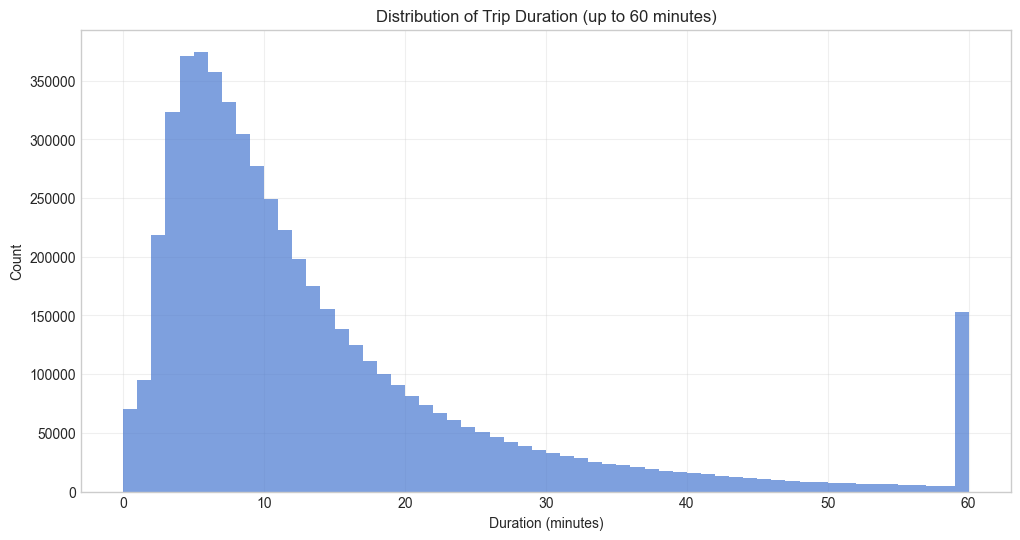

In [34]:
# Visualize the distribution (truncated for readability)
plt.figure(figsize=(12, 6))
plt.hist(df["trip_duration"].clip(0, 60), bins=60, alpha=0.7)
plt.title('Distribution of Trip Duration (up to 60 minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

With invalid timestamps removed, there should be no negative rides but there could be 0 minute duration rides. 

In [35]:
# Let's also check for negative durations
zero_minute_rides = (df["trip_duration"] == 0).sum()
print(f"Trips with zero duration: {zero_minute_rides} ({zero_minute_rides/len(df):.2%})")

# And extremely long durations (>24 hours)
very_long_durations = (df["trip_duration"] > 1440).sum()  # 1440 minutes = 24 hours
print(f"Trips longer than 24 hours: {very_long_durations:,} ({very_long_durations/len(df):.2%})")

print(f"Total invalid ride duration: {zero_minute_rides + very_long_durations}")

Trips with zero duration: 351 (0.01%)
Trips longer than 24 hours: 7,758 (0.14%)
Total invalid ride duration: 8109


**Note Issue:**
- Issue #4: Invalid ride durations 
- Columns: started_at, ended_at, trip_duration
- Affected Rows: 8109  
- Resolution: Drop affected rows

In [36]:
# Filter out rides with invalid durations
before_filter = len(df)
df = df[
    (df["trip_duration"] > 0) &
    (df["trip_duration"] <= 1440)  # 24 hours max
]
after_filter = len(df)

print(f"Filtered out {before_filter - after_filter:,} rides with invalid durations")
print(f"Retained {after_filter:,} rides ({after_filter/before_filter:.2%} of data)")

Filtered out 8,109 rides with invalid durations
Retained 5,394,082 rides (99.85% of data)


#### Extracting Time-Based Features

In [37]:
# Extract hour of the day
df["hour"] = df["started_at"].dt.hour

# Categorize into time periods
def categorize_day_period(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

df["day_period"] = df["hour"].apply(categorize_day_period)

In [38]:
# Extract day of week
df["day_of_week"] = df["started_at"].dt.day_of_week
df["day_of_week"] = df["day_of_week"].map(DAY_MAPPING)

# Make day of week categorical with proper ordering
df["day_of_week"] = pd.Categorical(
    df["day_of_week"],
    categories=list(DAY_MAPPING.values()),
    ordered=True
)

In [39]:
# Extract month
df["month"] = df["started_at"].dt.month
df["month"] = df["month"].map(MONTH_MAPPING)

# Make month categorical with proper ordering
df["month"] = pd.Categorical(
    df["month"],
    categories=list(MONTH_MAPPING.values()),
    ordered=True
)

In [40]:
# Preview the new columns
df[["hour", "day_period", "day_of_week", "month"]].tail()

hour day_period day_of_week    month
5933707     9    Morning      Friday  October
5933708    18    Evening    Saturday  October
5933709    16  Afternoon      Friday  October
5933710    23      Night      Friday  October
5933711    15  Afternoon   Wednesday  October

In [41]:
casual_hourly = df[(df['member_casual'] == 'casual')][["hour"]]

#### Additional Data Validation 

Validate member type column: 

In [42]:
# Check for invalid values
if df[~df["member_casual"].isin(["member", "casual"])].shape[0] <= 0:
  print('valid')

valid


In [43]:
# dataset summary
print(f"Date range: {df['started_at'].min()} to {df['started_at'].max()}")
print(f"\nFinal dataset shape: {df.shape}")

Date range: 2023-11-01 00:05:28 to 2024-10-31 23:55:39

Final dataset shape: (5394082, 18)


## Exploratory Data Analysis

Dive into understanding the patterns and differences between casual riders and members across various dimensions.


### Rider Type Distribution

Understand user base composition: 


In [44]:
# Analyze rider type distribution
trips_by_rider_group = df.groupby("member_casual").size()
rider_group_distribution = (trips_by_rider_group / trips_by_rider_group.sum() * 100).round(2)

# print(f"Total rides by rider group: {trips_by_rider_group}")
print(f"\nPercentage distribution: {rider_group_distribution}")


Percentage distribution: member_casual
casual    35.69
member    64.31
dtype: float64


### Temporal Usage Patterns

Understanding when different rider groups prefer to ride can reveal behavioral insights about their usage patterns.

#### Monthly Patterns

In [45]:
# Monthly usage patterns
monthly_usage = df.groupby(["member_casual", "month"], observed=False).size().unstack(fill_value=0)
monthly_pct = (monthly_usage.div(monthly_usage.sum(axis=1), axis=0) * 100).round(2)

# print("Monthly usage counts:")
# display(monthly_usage.T)
print("\nMonthly usage percentages:")
display(monthly_pct.T)


Monthly usage percentages:


member_casual  casual  member
month                        
January          1.14    3.28
February         2.30    4.85
March            3.93    5.92
April            6.13    7.50
May             10.74   10.01
June            13.68   10.68
July            14.87   11.34
August          14.77   11.59
September       15.18   12.39
October         10.18   10.67
November         4.65    7.13
December         2.42    4.63

In [46]:
# Calculate differences between groups
monthly_differences = monthly_pct.loc["casual"] - monthly_pct.loc["member"]
max_diff_month = monthly_differences.abs().idxmax()
max_diff_value = monthly_differences[max_diff_month]

print(f"\nKey insight: Largest difference occurs in {max_diff_month}")
print(f"({abs(max_diff_value):.1f}% {'higher casual usage' if max_diff_value > 0 else 'higher member usage'})")


Key insight: Largest difference occurs in July
(3.5% higher casual usage)


#### Daily Patterns


In [47]:
# Daily usage patterns  
daily_usage = df.groupby(["member_casual", "day_of_week"], observed=False).size().unstack(fill_value=0)
daily_pct = (daily_usage.div(daily_usage.sum(axis=1), axis=0) * 100).round(2)

# print("Daily usage counts:")
# display(daily_usage.T)
print("\nDaily usage percentages:")
display(daily_pct.T)


Daily usage percentages:


member_casual  casual  member
day_of_week                  
Monday          11.70   14.24
Tuesday         10.76   15.26
Wednesday       12.75   16.86
Thursday        12.75   16.06
Friday          14.60   14.02
Saturday        20.52   12.63
Sunday          16.92   10.92

In [48]:
# Calculate differences
daily_differences = daily_pct.loc["casual"] - daily_pct.loc["member"]
max_diff_day = daily_differences.abs().idxmax()
max_diff_value = daily_differences[max_diff_day]

print(f"\nKey insight: Largest difference occurs on {max_diff_day}")
print(f"({abs(max_diff_value):.1f}% {'higher casual usage' if max_diff_value > 0 else 'higher member usage'})")


Key insight: Largest difference occurs on Saturday
(7.9% higher casual usage)


#### Time of Day Patterns


In [49]:
# Time of day usage patterns
hourly_usage = df.groupby(["member_casual", "day_period"]).size().unstack(fill_value=0)
hourly_pct = (hourly_usage.div(hourly_usage.sum(axis=1), axis=0) * 100).round(2)

# print("Time period usage counts:")
# display(hourly_usage.T)
print("\nTime period usage percentages:")
display(hourly_pct.T)


Time period usage percentages:


member_casual  casual  member
day_period                   
Afternoon       37.82   32.70
Evening         27.86   28.73
Morning         21.76   29.97
Night           12.57    8.61

In [50]:
# Calculate differences
hourly_differences = hourly_pct.loc["casual"] - hourly_pct.loc["member"]
max_diff_period = hourly_differences.abs().idxmax()
max_diff_value = hourly_differences[max_diff_period]

print(f"\nKey insight: Largest difference occurs during {max_diff_period}")
print(f"({abs(max_diff_value):.1f}% {'higher casual usage' if max_diff_value > 0 else 'higher member usage.'})")


Key insight: Largest difference occurs during Morning
(8.2% higher member usage.)


### Trip Duration Analysis


In [51]:
# Trip duration statistics by rider group
duration_stats = df.groupby("member_casual")["trip_duration"].agg(["mean", "std", "count"])
trip_duration_gap = duration_stats.loc["casual", "mean"] - duration_stats.loc["member", "mean"]

print("Trip duration statistics:")
display(duration_stats)
print(f"Casual riders take {trip_duration_gap:.2f} minutes longer on average.")

Trip duration statistics:


mean        std    count
member_casual                               
casual         22.034049  44.440797  1925346
member         12.269310  20.904084  3468736

Casual riders take 9.76 minutes longer on average.


#### Duration Distribution Analysis


In [52]:
# Categorize trip durations for easier analysis
duration_bins = [0, 10, 20, 30, 40, 50, 60, 120]
duration_labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60+"]
df["trip_duration_category"] = pd.cut(
    df["trip_duration"],
    bins=duration_bins,
    labels=duration_labels,
    include_lowest=True,
)

In [53]:
# Calculate duration distribution
trip_duration_dist = df.groupby(["member_casual", "trip_duration_category"], observed=True).size().unstack(fill_value=0)
trip_duration_dist_pct = (trip_duration_dist.div(trip_duration_dist.sum(axis=1), axis=0) * 100).round(2)

print("Trip duration distribution (%):")
display(trip_duration_dist_pct.T)

Trip duration distribution (%):


member_casual           casual  member
trip_duration_category                
0-10                     40.11   56.80
10-20                    30.17   28.64
20-30                    12.81    8.89
30-40                     6.24    3.43
40-50                     3.60    1.34
50-60                     2.28    0.44
60+                       4.78    0.46

In [54]:
# Calculate differences
duration_differences = trip_duration_dist_pct.loc["casual"] - trip_duration_dist_pct.loc["member"]
max_diff_duration = duration_differences.abs().idxmax()
max_diff_value = duration_differences[max_diff_duration]

print(f"\nKey insight: Largest difference occurs in the {max_diff_duration} minute duration category")
print(f"({abs(max_diff_value):.1f}% {'higher casual usage' if max_diff_value > 0 else 'higher member usage.'})")


Key insight: Largest difference occurs in the 0-10 minute duration category
(16.7% higher member usage.)


### Bike Type Preferences


Different rider groups may have preferences for different types of bikes available in the system.


In [56]:
# Bike preference analysis
bike_preference_counts = df.groupby(["member_casual", "rideable_type"]).size().unstack(fill_value=0)
bike_preference_pct = (bike_preference_counts.div(bike_preference_counts.sum(axis=1), axis=0) * 100).round(2)

# print("Bike type usage counts:")
# display(bike_preference_counts.T)
print("\nBike type usage percentages:")
display(bike_preference_pct.T)


Bike type usage percentages:


member_casual     casual  member
rideable_type                   
classic_bike       50.87   52.19
electric_bike      46.20   46.47
electric_scooter    2.93    1.34

Both groups prefer classic bikes. 

### Station Popularity


Understanding which stations are most popular can reveal geographic usage patterns and help identify high-traffic areas.

Define a function to find the most popular stations:

In [57]:
def get_top_stations(df, station_column, n=10):
    """Get top n stations by rider group with location data."""
    lat_column = "start_lat" if station_column == "start_station_name" else "end_lat"
    lng_column = "start_lng" if station_column == "start_station_name" else "end_lng"
    
    top_stations = (
        df.groupby(["member_casual", station_column, lat_column, lng_column])
        .size()
        .reset_index(name="count")
        .sort_values(["member_casual", "count"], ascending=[True, False])
        .groupby("member_casual")
        .head(n)
        .rename(columns={lat_column: "latitude", lng_column: "longitude"})
    )
    
    return top_stations

#### Top Start Stations

In [58]:
# Get top start stations
top_start_stations = get_top_stations(df, "start_station_name")
top_start_stations_casual = top_start_stations.iloc[:10, 1:]
top_start_stations_member = top_start_stations.iloc[10:, 1:]

print("Top 10 Start Stations by Rider Group:")
print("Casual")
display(top_start_stations_casual)
print("Member")
display(top_start_stations_member)

Top 10 Start Stations by Rider Group:
Casual


start_station_name   latitude  longitude  count
345449             Streeter Dr & Grand Ave  41.892278 -87.612043  44430
123759   DuSable Lake Shore Dr & Monroe St  41.880958 -87.616743  29615
236022               Michigan Ave & Oak St  41.900960 -87.623777  21435
128463  DuSable Lake Shore Dr & North Blvd  41.911722 -87.626804  20056
244194                     Millennium Park  41.881032 -87.624084  19141
301733                      Shedd Aquarium  41.867226 -87.615355  17854
133562                      Dusable Harbor  41.886976 -87.612813  15748
351725                 Theater on the Lake  41.926277 -87.630834  14442
230164               Michigan Ave & 8th St  41.872773 -87.623981  11834
4331                     Adler Planetarium  41.866095 -87.607267  11113

Member


start_station_name   latitude  longitude  count
778101             Kingsbury St & Kinzie St  41.889177 -87.638506  22174
588538         Clinton St & Washington Blvd  41.883380 -87.641170  19538
532183                    Clark St & Elm St  41.902973 -87.631280  19193
581890              Clinton St & Madison St  41.882752 -87.641190  18053
1086084            University Ave & 57th St  41.791478 -87.599861  16013
1117517               Wells St & Concord Ln  41.912133 -87.634656  15710
1122356                   Wells St & Elm St  41.903222 -87.634324  14993
632681                Dearborn St & Erie St  41.893992 -87.629318  14882
567090            Clinton St & Jackson Blvd  41.878317 -87.640981  14645
658472   DuSable Lake Shore Dr & North Blvd  41.911722 -87.626804  14432

Identify which stations are popular starting points for both casual riders and members: 

In [59]:
# Convert to sets of station names
casual_set = set(top_start_stations_casual['start_station_name'])
member_set = set(top_start_stations_member['start_station_name'])

# Find the intersection
overlap = casual_set.intersection(member_set)

# Output
print(f"Number of overlapping stations: {len(overlap)}")
print(f"Overlapping stations: {overlap if overlap else 'None'}")


Number of overlapping stations: 1
Overlapping stations: {'DuSable Lake Shore Dr & North Blvd'}


Interestingly, there is minimal overlap between the top 10 starting point stations for members and casual users, suggesting distinct usage patterns between the two groups.

#### Top End Stations


Get top end stations

In [60]:
top_end_stations = get_top_stations(df, "end_station_name")
top_end_stations_casual = top_end_stations.iloc[:10, 1:]
top_end_stations_member = top_end_stations.iloc[10:, 1:]

print("Top 10 End Stations by Rider Group:")
print("Casual")
display(top_end_stations_casual)
print("Member")
display(top_end_stations_member)

Top 10 End Stations by Rider Group:
Casual


end_station_name   latitude  longitude  count
2018             Streeter Dr & Grand Ave  41.892278 -87.612043  54470
439    DuSable Lake Shore Dr & Monroe St  41.880958 -87.616743  31949
445   DuSable Lake Shore Dr & North Blvd  41.911722 -87.626804  26537
1000               Michigan Ave & Oak St  41.900960 -87.623777  25821
1026                     Millennium Park  41.881032 -87.624084  24261
1888                      Shedd Aquarium  41.867226 -87.615355  18951
2024                 Theater on the Lake  41.926277 -87.630834  18124
454                       Dusable Harbor  41.886976 -87.612813  16728
975                Michigan Ave & 8th St  41.872773 -87.623981  12378
2077              Wabash Ave & Grand Ave  41.891466 -87.626761  11641

Member


end_station_name   latitude  longitude  count
2942      Kingsbury St & Kinzie St  41.889177 -87.638506  29367
2527  Clinton St & Washington Blvd  41.883380 -87.641170  29166
2521       Clinton St & Madison St  41.882752 -87.641190  26192
2475             Clark St & Elm St  41.902973 -87.631280  24996
4275         Wells St & Concord Ln  41.912133 -87.634656  21116
4282             Wells St & Elm St  41.903222 -87.634324  20396
2511     Clinton St & Jackson Blvd  41.878317 -87.640981  20249
4163        State St & Chicago Ave  41.896617 -87.628579  19872
4213      University Ave & 57th St  41.791478 -87.599861  19271
2398         Canal St & Madison St  41.882409 -87.639767  18557

In [61]:
# Convert to sets of station names
casual_set = set(top_end_stations_casual['end_station_name'])
member_set = set(top_end_stations_member['end_station_name'])

# Find the intersection
overlap = casual_set.intersection(member_set)

# Output
print(f"Number of overlapping stations: {len(overlap)}")
print(f"Overlapping stations: {overlap if overlap else 'None'}")


Number of overlapping stations: 0
Overlapping stations: None


Here again, we see 0 overlap between the rider's popular destination stations. It would be useful to highlight this variation further with a map. 

### Station Usage Concentration

Analyze if certain rider groups tend to use a smaller set of stations more heavily, or if their usage is more evenly spread across the network:

In [62]:
def calculate_gini(x):
    """Calculate Gini coefficient for measuring concentration."""
    x = np.asarray(x)
    if np.any(x < 0):
        raise ValueError("Input values must be non-negative.")
    x = x / np.sum(x)  # Normalize
    return 0.5 * np.abs(np.subtract.outer(x, x)).mean() / np.mean(x)

In [63]:
# Calculate station concentration metrics
def analyze_station_concentration(df, station_type):
    """Analyze how concentrated station usage is for each rider group."""
    station_column = f"{station_type}_station_name"
    
    station_counts = (
        df.groupby(["member_casual", station_column])
        .size()
        .reset_index(name="count")
    )
    
    concentration_stats = station_counts.groupby("member_casual").agg(
        total_stations=("count", "count"),
        top_10_share=("count", lambda x: x.nlargest(10).sum() / x.sum() * 100),
        gini_coefficient=("count", calculate_gini)
    ).round(3)
    
    return concentration_stats

In [64]:
# Analyze start station concentration
start_concentration = analyze_station_concentration(df, "start")
print("Start Station Concentration Analysis:")
display(start_concentration)

Start Station Concentration Analysis:


total_stations  top_10_share  gini_coefficient
member_casual                                                
casual                   1640        13.630             0.822
member                   1703         7.329             0.821

In [65]:
# Analyze end station concentration  
end_concentration = analyze_station_concentration(df, "end")
print("\nEnd Station Concentration Analysis:")
display(end_concentration)


End Station Concentration Analysis:


total_stations  top_10_share  gini_coefficient
member_casual                                                
casual                   1675        14.091             0.828
member                   1700         7.367             0.820

In [66]:
print("\nInterpretation:")
print(f"- Casual riders: Top 10 start stations account for {start_concentration.loc['casual', 'top_10_share']:.1f}% of rides")
print(f"- Members: Top 10 start stations account for {start_concentration.loc['member', 'top_10_share']:.1f}% of rides")
print(f"- Casual riders: Top 10 end stations account for {end_concentration.loc['casual', 'top_10_share']:.1f}% of rides") 
print(f"- Members: Top 10 end stations account for {end_concentration.loc['member', 'top_10_share']:.1f}% of rides")


Interpretation:
- Casual riders: Top 10 start stations account for 13.6% of rides
- Members: Top 10 start stations account for 7.3% of rides
- Casual riders: Top 10 end stations account for 14.1% of rides
- Members: Top 10 end stations account for 7.4% of rides


### Summary of Key Findings

This exploratory data analysis reveals distinct usage patterns between casual riders and annual members of the Cyclistic bike-share program, offering valuable insights for targeted marketing strategies.
 
**Ridership and Usage:**
- Annual members account for approximately 57% of total rides, while casual riders make up the remaining 43%.
- Weekday usage is dominant for both groups, particularly during commuting hours (8-9 AM, 5-6 PM) for members. Casual riders show higher weekend usage, peaking on Saturdays.
- Monthly trends reveal peak usage during summer months (June-August) for both groups, with casual ridership significantly higher during these months.

**Trip Behavior:**
- Casual riders demonstrate a preference for longer trips, with an average trip duration of ~26 minutes compared to ~13 minutes for members. This difference is consistent across days of the week.
- Both casual riders and members primarily use classic bikes, indicating a universal preference for this bike type.
- Station usage is significantly more concentrated among members, suggesting habitual commuting patterns. Casual riders exhibit more diverse station usage, likely reflecting exploratory or leisure-based riding.

In [67]:
# Create comprehensive summary statistics
summary_data = []

# Basic metrics
total_rides = len(df)
date_range = f"{df['started_at'].min().strftime('%b %Y')} - {df['started_at'].max().strftime('%b %Y')}"

# Rider distribution
casual_count = (df['member_casual'] == 'casual').sum()
member_count = (df['member_casual'] == 'member').sum()
casual_pct = (casual_count / total_rides) * 100
member_pct = (member_count / total_rides) * 100

# Duration statistics
casual_avg_duration = duration_stats.loc['casual', 'mean']
member_avg_duration = duration_stats.loc['member', 'mean']
casual_median_duration = df[df['member_casual'] == 'casual']['trip_duration'].median()
member_median_duration = df[df['member_casual'] == 'member']['trip_duration'].median()

# Peak usage analysis
casual_peak_day = daily_pct.loc['casual'].idxmax()
member_peak_day = daily_pct.loc['member'].idxmax()
casual_peak_month = monthly_pct.loc['casual'].idxmax()
member_peak_month = monthly_pct.loc['member'].idxmax()
casual_peak_hour = df[df['member_casual'] == 'casual']['hour'].mode()[0]
member_peak_hour = df[df['member_casual'] == 'member']['hour'].mode()[0]

# Bike preferences
casual_bike_pref = bike_preference_pct.loc['casual'].idxmax()
member_bike_pref = bike_preference_pct.loc['member'].idxmax()

# Station concentration
casual_top10_concentration = start_concentration.loc['casual', 'top_10_share']
member_top10_concentration = start_concentration.loc['member', 'top_10_share']

# Create the summary table
summary_table = pd.DataFrame({
    'Metric': [
        'Dataset Overview',
        'Total Rides',
        'Date Range',
        'Data Quality',
        '',
        'Rider Distribution',
        'Casual Riders',
        'Annual Members',
        '',
        'Trip Duration (Average)',
        'Casual Riders',
        'Annual Members',
        'Duration Difference',
        '',
        'Trip Duration (Median)',
        'Casual Riders',
        'Annual Members',
        '',
        'Peak Usage Patterns',
        'Casual Peak Day',
        'Member Peak Day',
        'Casual Peak Month',
        'Member Peak Month',
        'Casual Peak Hour',
        'Member Peak Hour',
        '',
        'Bike Preferences',
        'Casual Preferred Type',
        'Member Preferred Type',
        '',
        'Station Concentration',
        'Casual Top 10 Share',
        'Member Top 10 Share',
    ],
    'Value': [
        '',
        f'{total_rides:,}',
        date_range,
        '90.4% complete after cleaning',
        '',
        '',
        f'{casual_count:,} ({casual_pct:.1f}%)',
        f'{member_count:,} ({member_pct:.1f}%)',
        '',
        '',
        f'{casual_avg_duration:.1f} minutes',
        f'{member_avg_duration:.1f} minutes',
        f'+{trip_duration_gap:.1f} minutes (casual longer)',
        '',
        '',
        f'{casual_median_duration:.1f} minutes',
        f'{member_median_duration:.1f} minutes',
        '',
        '',
        f'{casual_peak_day} ({daily_pct.loc["casual", casual_peak_day]:.1f}%)',
        f'{member_peak_day} ({daily_pct.loc["member", member_peak_day]:.1f}%)',
        f'{casual_peak_month} ({monthly_pct.loc["casual", casual_peak_month]:.1f}%)',
        f'{member_peak_month} ({monthly_pct.loc["member", member_peak_month]:.1f}%)',
        f'{casual_peak_hour}:00',
        f'{member_peak_hour}:00',
        '',
        '',
        f'{casual_bike_pref.replace("_", " ").title()}',
        f'{member_bike_pref.replace("_", " ").title()}',
        '',
        '',
        f'{casual_top10_concentration:.1f}% of rides',
        f'{member_top10_concentration:.1f}% of rides',
    ]
})

# Display the table with enhanced formatting
print("="*80)
print("CYCLISTIC BIKE-SHARE ANALYSIS - COMPREHENSIVE SUMMARY")
print("="*80)
print()

# Create a styled display
for idx, row in summary_table.iterrows():
    metric = row['Metric']
    value = row['Value']
    
    if metric == '':
        print()
    elif value == '':
        print(f"{'='*60}")
        print(f"{metric.upper():^60}")
        print(f"{'='*60}")
    else:
        print(f"{metric:<35} | {value}")

print()
print("="*80)

CYCLISTIC BIKE-SHARE ANALYSIS - COMPREHENSIVE SUMMARY

                      DATASET OVERVIEW                      
Total Rides                         | 5,394,082
Date Range                          | Nov 2023 - Oct 2024
Data Quality                        | 90.4% complete after cleaning

                     RIDER DISTRIBUTION                     
Casual Riders                       | 1,925,346 (35.7%)
Annual Members                      | 3,468,736 (64.3%)

                  TRIP DURATION (AVERAGE)                   
Casual Riders                       | 22.0 minutes
Annual Members                      | 12.3 minutes
Duration Difference                 | +9.8 minutes (casual longer)

                   TRIP DURATION (MEDIAN)                   
Casual Riders                       | 12.6 minutes
Annual Members                      | 8.8 minutes

                    PEAK USAGE PATTERNS                     
Casual Peak Day                     | Saturday (20.5%)
Member Peak Day          

## Data Visualization

Create compelling visualizations to support analysis and recommendations for converting casual riders to annual members.

In [68]:
# Enhanced visualization setup
def set_visualization_style():
    """Set consistent styling for all visualizations."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 11,
        'figure.titlesize': 18,
        'axes.grid': True,
        'grid.alpha': 0.3
    })

In [69]:
def format_plot(ax, title, xlabel, ylabel, legend_title=None):
    """Apply consistent formatting to plots."""
    ax.set_title(title, fontweight='bold', pad=20)
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    if legend_title and ax.get_legend():
        ax.legend(title=legend_title)
    ax.grid(True, alpha=0.3)

# Set style for all subsequent plots
set_visualization_style()

### 1. Rider Composition Overview

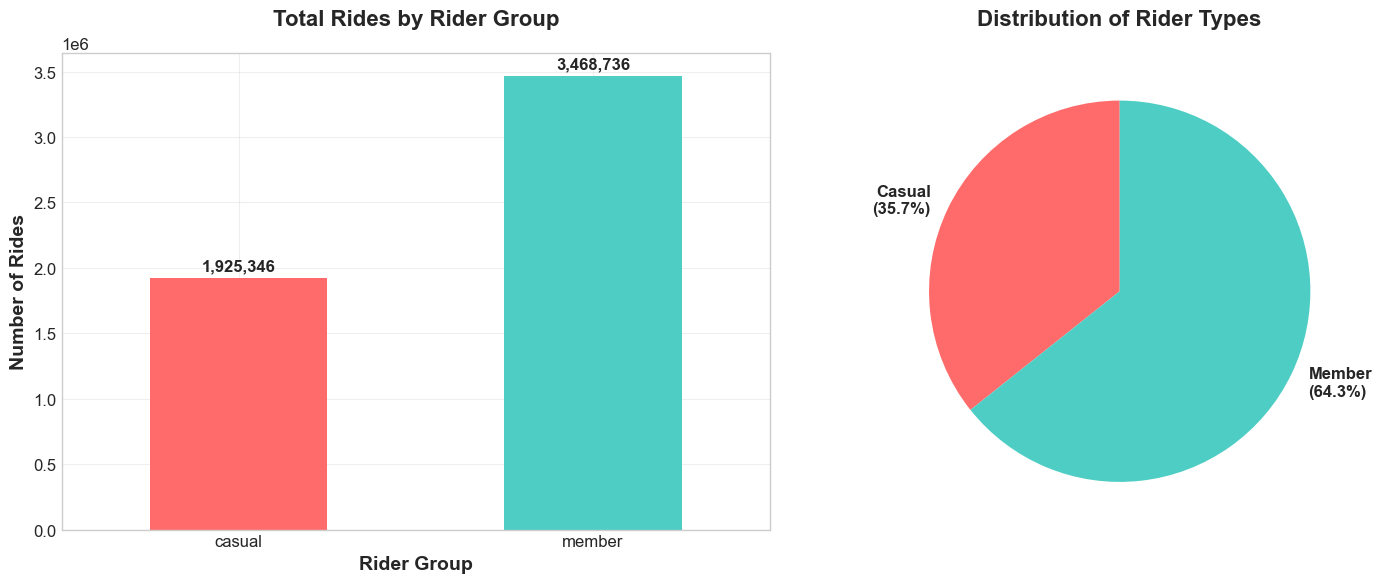

In [70]:
# Create rider composition visualization
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
trips_by_rider_group.plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4'])
format_plot(ax1, 'Total Rides by Rider Group', 'Rider Group', 'Number of Rides')
ax1.tick_params(axis='x', rotation=0)

# Add value labels on bars
for i, v in enumerate(trips_by_rider_group.values):
    ax1.text(i, v + trips_by_rider_group.max() * 0.01, f'{v:,}', 
             ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['#FF6B6B', '#4ECDC4']
wedges, texts, autotexts = ax2.pie(rider_group_distribution.values, 
                                  labels=[f'{label.title()}\n({value:.1f}%)' 
                                         for label, value in rider_group_distribution.items()],
                                  colors=colors, autopct='', startangle=90)

ax2.set_title('Distribution of Rider Types', fontweight='bold', pad=20)

# Enhance pie chart text
for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

plt.tight_layout()
plt.show()

### 2. Temporal Usage Patterns

#### Monthly Usage Trends

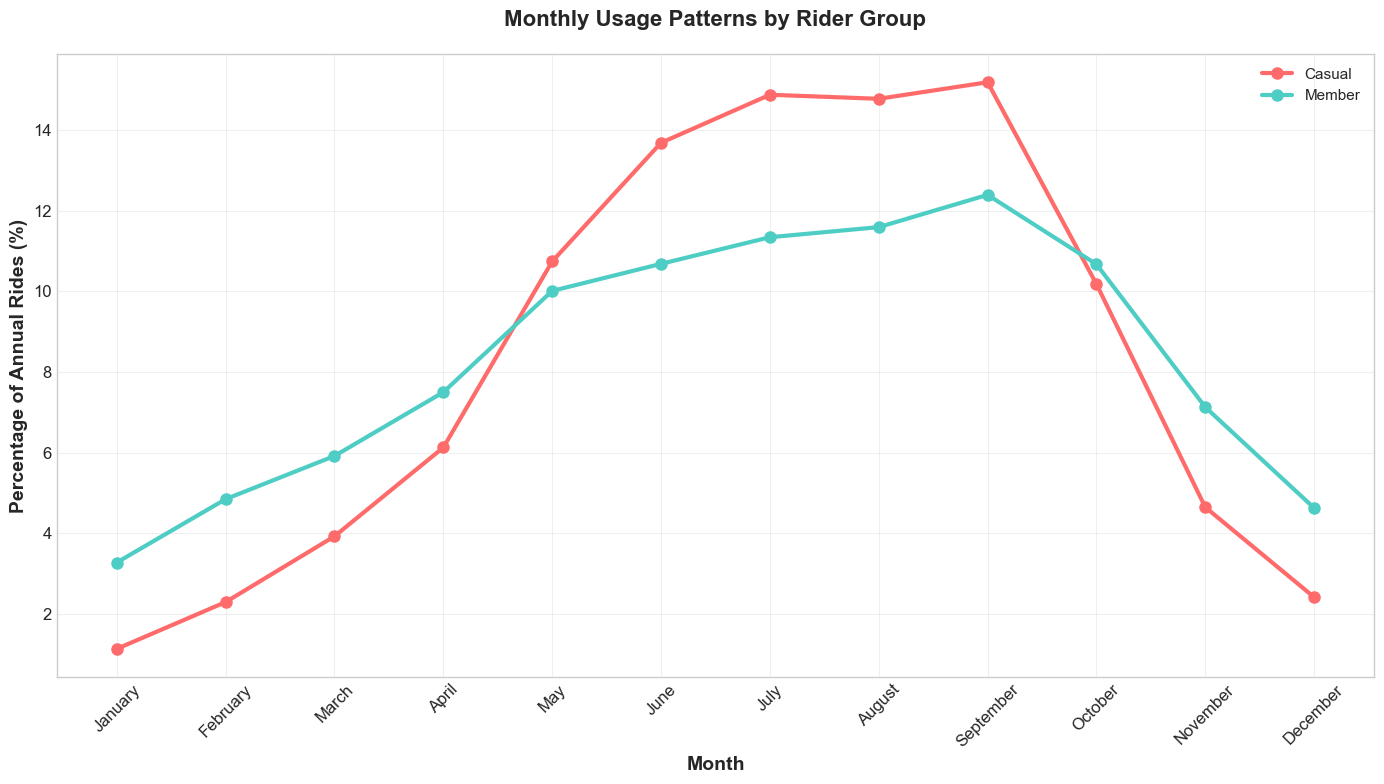

In [71]:
# Monthly usage patterns
fig2, ax = plt.subplots(figsize=(14, 8))

# Create line plot with markers
for rider_type in ['casual', 'member']:
    values = monthly_pct.loc[rider_type]
    color = '#FF6B6B' if rider_type == 'casual' else '#4ECDC4'
    ax.plot(values.index, values.values, marker='o', linewidth=3, 
           markersize=8, label=rider_type.title(), color=color)

format_plot(ax, 'Monthly Usage Patterns by Rider Group', 
           'Month', 'Percentage of Annual Rides (%)', 'Rider Group')

# Highlight peak months
casual_peak = monthly_pct.loc['casual'].idxmax()
member_peak = monthly_pct.loc['member'].idxmax()

ax.tick_params(axis='x', rotation=45)
ax.legend(['Casual', 'Member'])

plt.tight_layout()
plt.show()

#### Weekly Usage Patterns

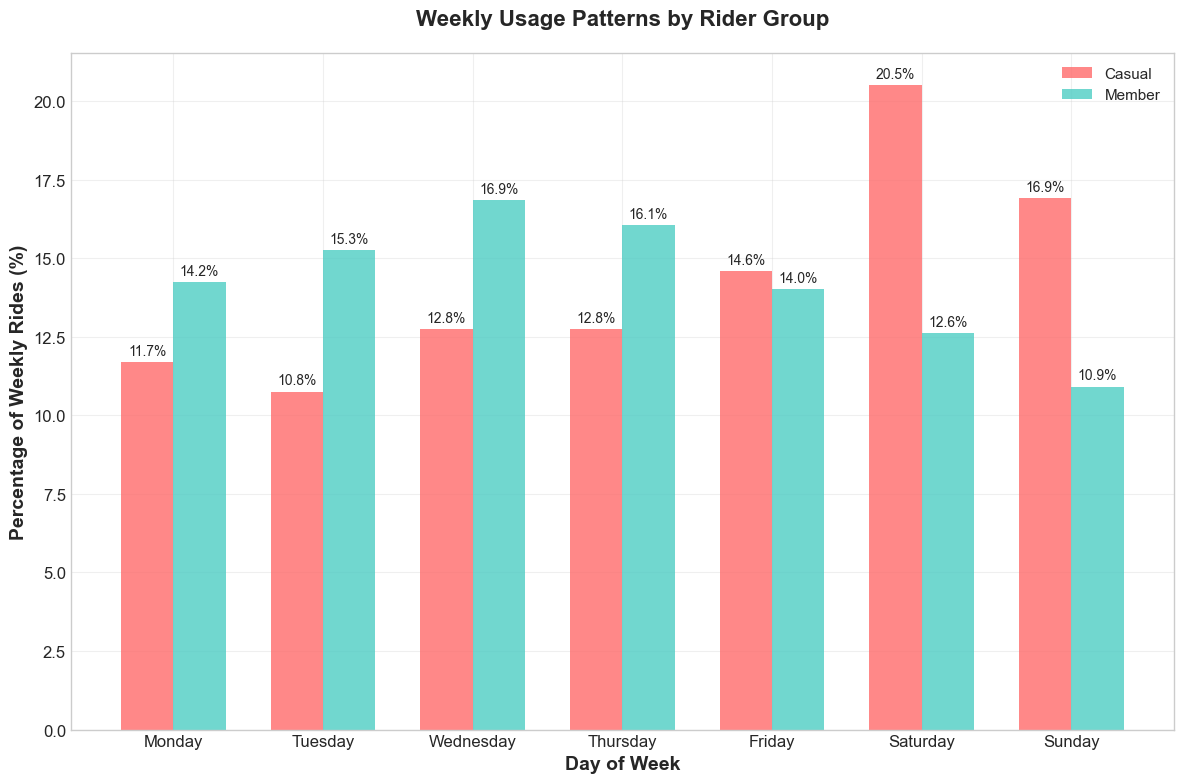

In [72]:
fig3, ax = plt.subplots(figsize=(12, 8))

# Create grouped bar chart
x = np.arange(len(daily_pct.columns))
width = 0.35

bars1 = ax.bar(x - width/2, daily_pct.loc['casual'], width, 
               label='Casual', color='#FF6B6B', alpha=0.8)
bars2 = ax.bar(x + width/2, daily_pct.loc['member'], width,
               label='Member', color='#4ECDC4', alpha=0.8)

format_plot(ax, 'Weekly Usage Patterns by Rider Group',
           'Day of Week', 'Percentage of Weekly Rides (%)', 'Rider Group')

ax.set_xticks(x)
ax.set_xticklabels(daily_pct.columns)
ax.legend(['Casual', 'Member'])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3), textcoords="offset points",
                   ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


#### Time of Day Usage

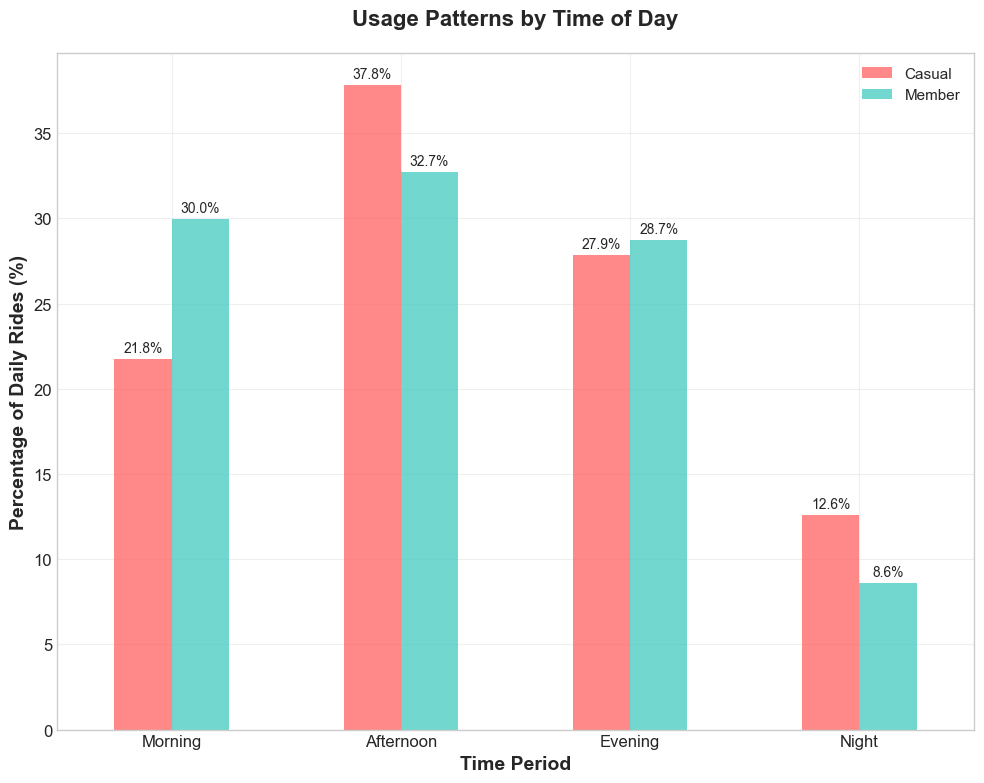

In [73]:
# Time of Day Usage with Value Labels
fig4, ax = plt.subplots(figsize=(10, 8))

# Create grouped bar chart for time periods
period_order = ['Morning', 'Afternoon', 'Evening', 'Night']
hourly_pct_ordered = hourly_pct.reindex(columns=period_order)

# Plot the bars
bars = hourly_pct_ordered.T.plot(kind='bar', ax=ax, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
format_plot(ax, 'Usage Patterns by Time of Day',
           'Time Period', 'Percentage of Daily Rides (%)', 'Rider Group')

ax.tick_params(axis='x', rotation=0)
ax.legend(['Casual', 'Member'])

# Add value labels on bars
bars_casual = ax.containers[0]  # First series (Casual)
bars_member = ax.containers[1]  # Second series (Member)

# Add value labels on bars
for bars in [bars_casual, bars_member]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3), textcoords="offset points",
                   ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### 3. Ride Duration Analysis

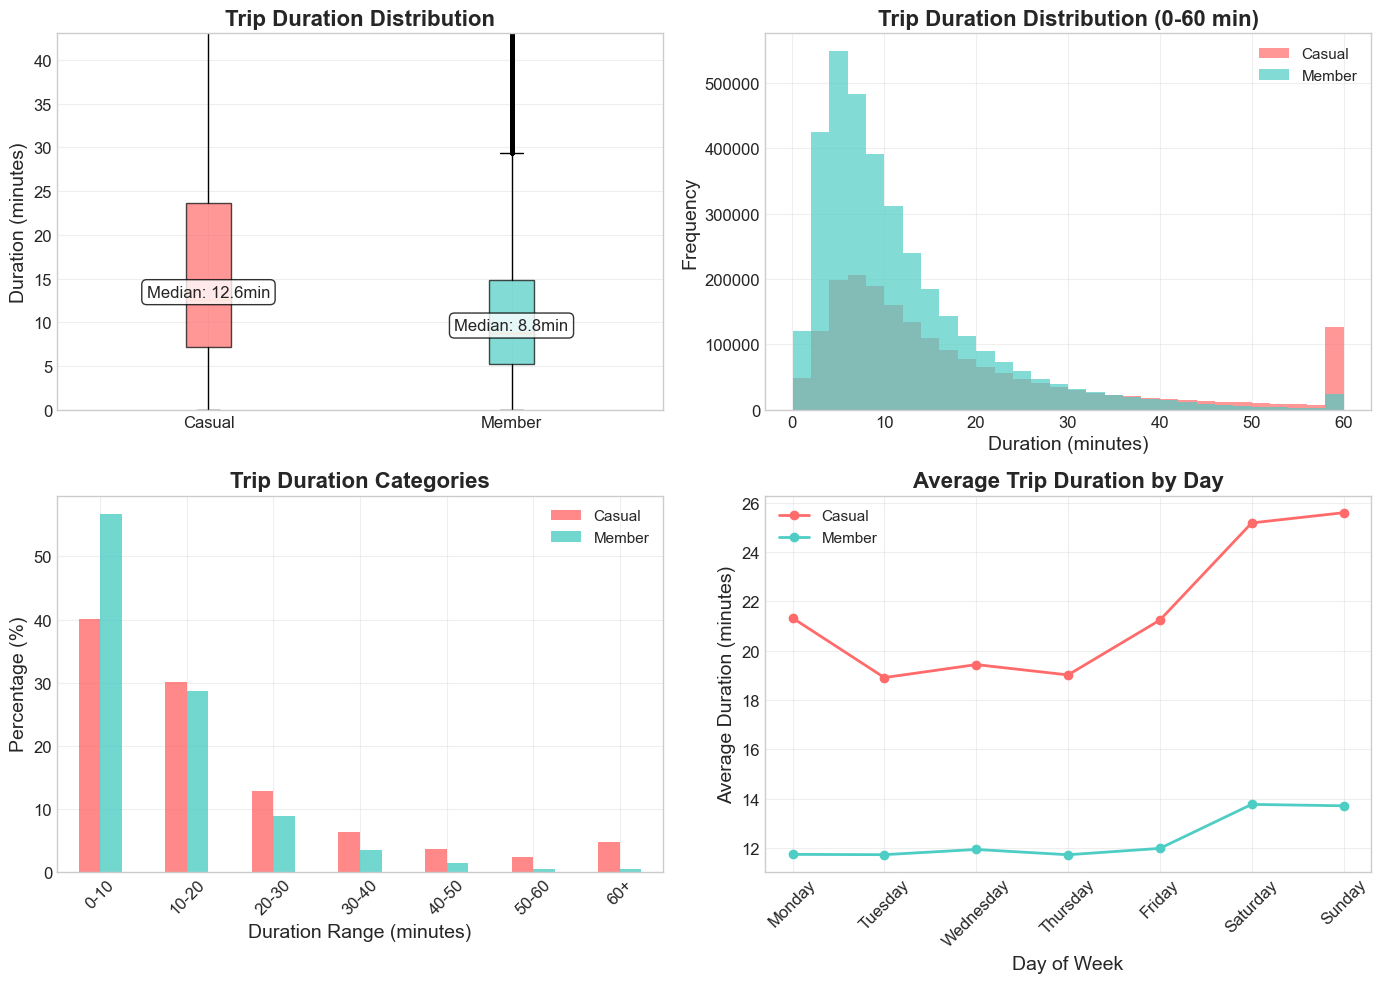

In [74]:
# Create comprehensive duration analysis
fig5, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Boxplot comparison
duration_data = [df[df['member_casual'] == 'casual']['trip_duration'],
                df[df['member_casual'] == 'member']['trip_duration']]

box_plot = ax1.boxplot(duration_data, tick_labels=['Casual', 'Member'], 
                      patch_artist=True, flierprops={'markersize': 2, 'alpha': 0.3})

# Color the boxes
colors = ['#FF6B6B', '#4ECDC4']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_title('Trip Duration Distribution', fontweight='bold')
ax1.set_ylabel('Duration (minutes)')
ax1.set_ylim(0, df['trip_duration'].quantile(0.95))  # Remove extreme outliers for clarity

# Add median labels
for i, group in enumerate(['casual', 'member']):
    median = df[df['member_casual'] == group]['trip_duration'].median()
    ax1.text(i+1, median, f'Median: {median:.1f}min', 
            ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Histogram comparison
for i, (group, color) in enumerate(zip(['casual', 'member'], colors)):
    data = df[df['member_casual'] == group]['trip_duration']
    ax2.hist(data.clip(0, 60), bins=30, alpha=0.7, label=group.title(), color=color)

ax2.set_title('Trip Duration Distribution (0-60 min)', fontweight='bold')
ax2.set_xlabel('Duration (minutes)')
ax2.set_ylabel('Frequency')
ax2.legend()

# Duration categories
trip_duration_dist_pct.T.plot(kind='bar', ax=ax3, color=colors, alpha=0.8)
ax3.set_title('Trip Duration Categories', fontweight='bold')
ax3.set_xlabel('Duration Range (minutes)')
ax3.set_ylabel('Percentage (%)')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(['Casual', 'Member'])

# Average duration by day of week
duration_by_day = df.groupby(['member_casual', 'day_of_week'], observed=True)['trip_duration'].mean().unstack(level=0)
duration_by_day.plot(kind='line', ax=ax4, marker='o', linewidth=2, markersize=6, color=colors)
ax4.set_title('Average Trip Duration by Day', fontweight='bold')
ax4.set_xlabel('Day of Week')
ax4.set_ylabel('Average Duration (minutes)')
ax4.legend(['Casual', 'Member'])
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 4. Bike Type Preferences

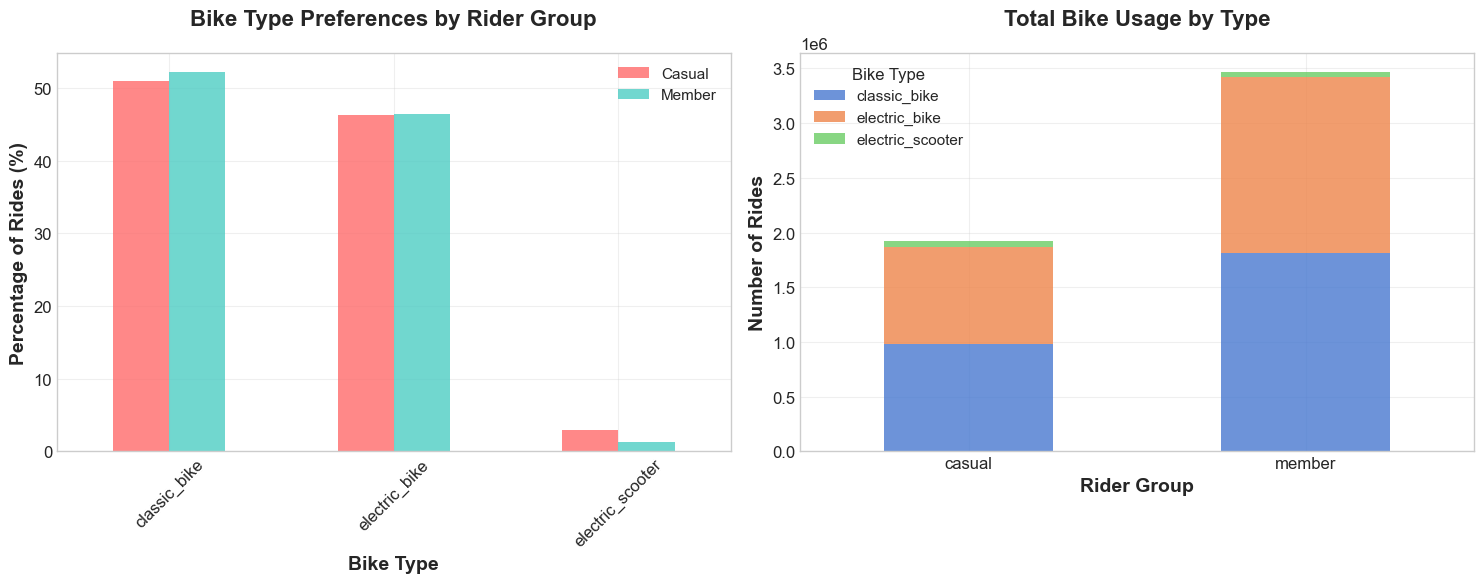

In [75]:
fig6, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Grouped bar chart
bike_preference_pct.T.plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
format_plot(ax1, 'Bike Type Preferences by Rider Group',
           'Bike Type', 'Percentage of Rides (%)', 'Rider Group')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(['Casual', 'Member'])

# Stacked bar chart
bike_preference_counts.plot(kind='bar', stacked=True, ax=ax2, alpha=0.8)
format_plot(ax2, 'Total Bike Usage by Type',
           'Rider Group', 'Number of Rides', 'Bike Type')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### 5. Station Popularity Analysis

#### 5.1 Top Start Stations by Rider Type

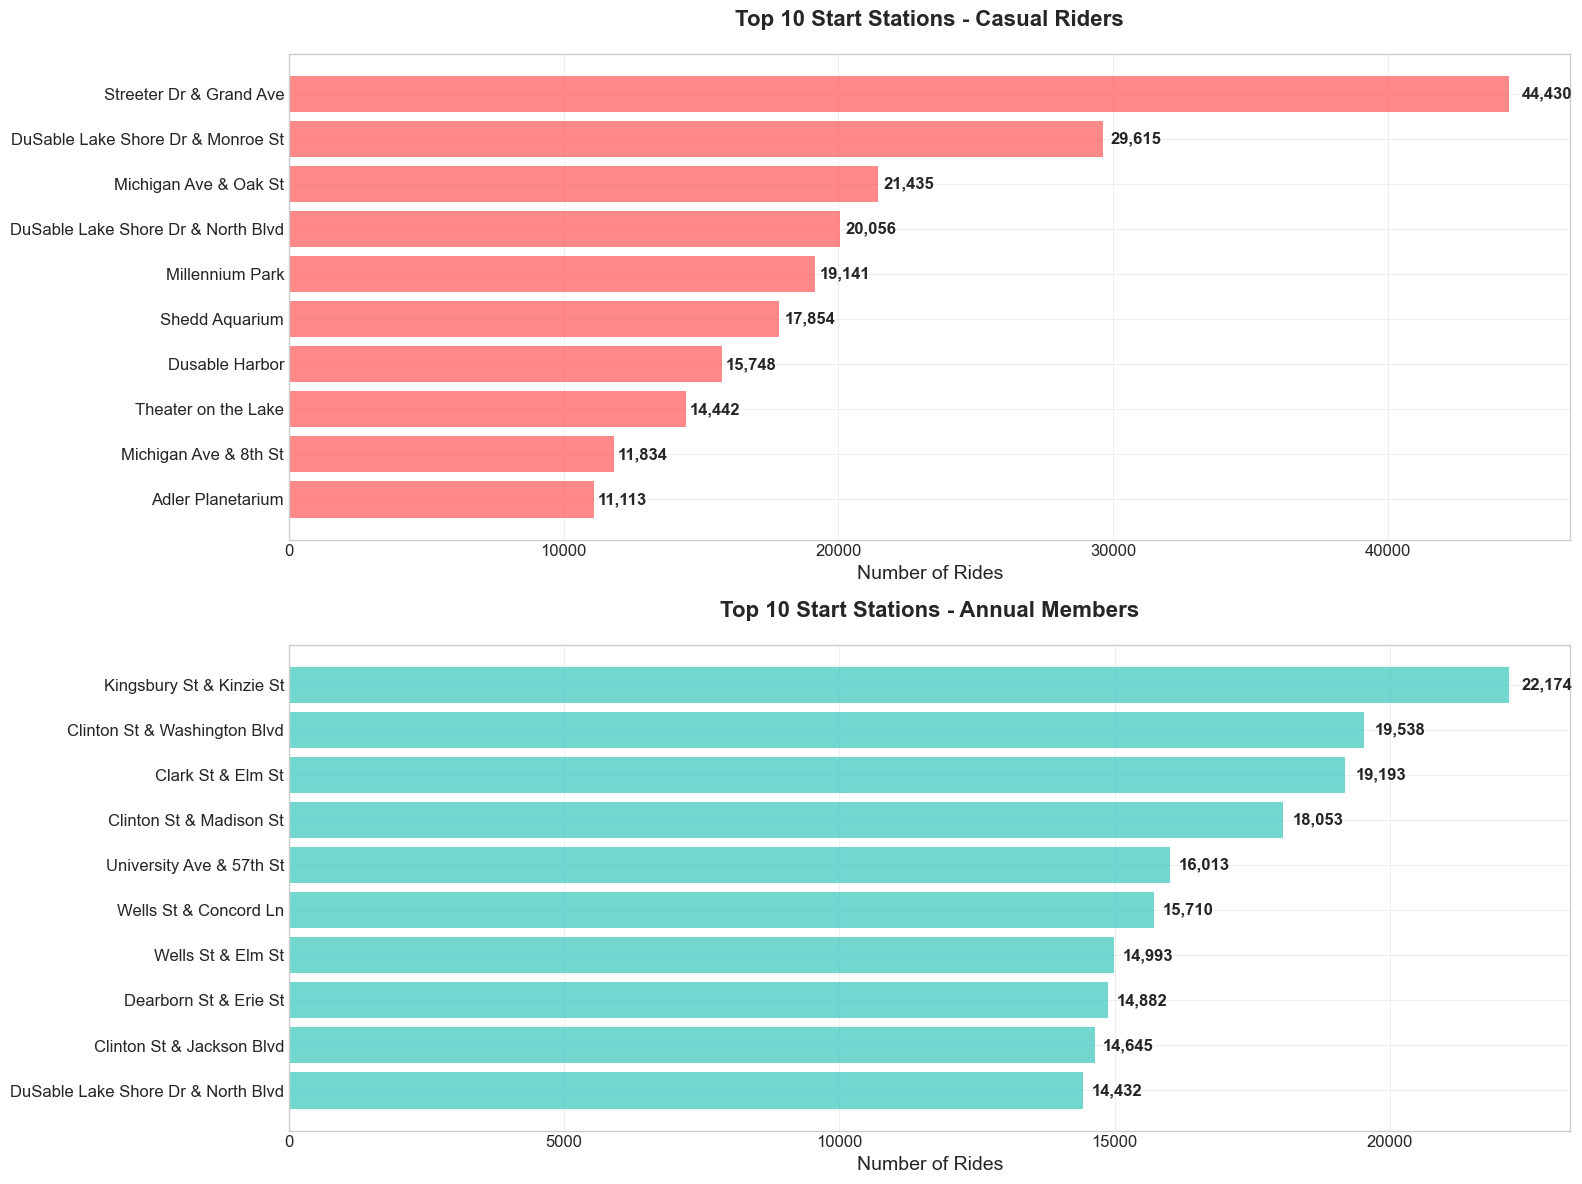

In [76]:
# Get top 10 stations for visualization
top_start_casual = top_start_stations_casual
top_start_member = top_start_stations_member

fig7, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Top casual stations
ax1.barh(range(len(top_start_casual)), top_start_casual['count'], color='#FF6B6B', alpha=0.8)
ax1.set_yticks(range(len(top_start_casual)))
ax1.set_yticklabels(top_start_casual['start_station_name'])
ax1.set_title('Top 10 Start Stations - Casual Riders', fontweight='bold', pad=20)
ax1.set_xlabel('Number of Rides')
ax1.invert_yaxis()

# Add value labels
for i, v in enumerate(top_start_casual['count']):
    ax1.text(v + v*0.01, i, f'{v:,}', va='center', ha='left', fontweight='bold')

# Top member stations  
ax2.barh(range(len(top_start_member)), top_start_member['count'], color='#4ECDC4', alpha=0.8)
ax2.set_yticks(range(len(top_start_member)))
ax2.set_yticklabels(top_start_member['start_station_name'])
ax2.set_title('Top 10 Start Stations - Annual Members', fontweight='bold', pad=20)
ax2.set_xlabel('Number of Rides')
ax2.invert_yaxis()

# Add value labels
for i, v in enumerate(top_start_member['count']):
    ax2.text(v + v*0.01, i, f'{v:,}', va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

#### 5.2 Geospatial View of Top Start Stations

In [77]:
# Import required libraries for plotting
import plotly.express as px
import plotly.offline as pyo

# Initialize plotly for notebook display
pyo.init_notebook_mode(connected=False)

# Get unique coordinates for each station
station_coords = df.groupby('start_station_name').agg({
    'start_lat': 'first',
    'start_lng': 'first'
}).reset_index()

# Merge station coordinates with usage data for both rider types
casual_map_data = top_start_casual.merge(station_coords, on='start_station_name', how='left')
member_map_data = top_start_member.merge(station_coords, on='start_station_name', how='left')

casual_map_data['rider_type'] = 'Casual'
member_map_data['rider_type'] = 'Member'
combined_map_data = pd.concat([casual_map_data, member_map_data])


# Calculate percent within each group
combined_map_data['percent'] = combined_map_data.groupby('rider_type')['count'].transform(lambda x: x / x.sum() * 100)

# Format hover text
combined_map_data['hover_text'] = combined_map_data.apply(
    lambda row: f"{row['start_station_name']}<br>{row['percent']:.1f}% of {row['rider_type']} Rides", axis=1
)

# Create map
fig = px.scatter_mapbox(
    combined_map_data,
    lat='start_lat',
    lon='start_lng',
    size='count',
    color='rider_type',
    hover_name=None,
    hover_data={'hover_text': True, 'count': False, 'start_lat': False, 'start_lng': False},
    title='Top Start Stations by Rider Group',
    mapbox_style='carto-positron',
    zoom=11,
    height=600,
    size_max=35,
    color_discrete_map={
        'Casual': '#FF6B6B',
        'Member': '#4ECDC4'
    }
)
# Adjust layout 
fig.update_traces(hovertemplate='%{customdata[0]}<extra></extra>')  #
fig.update_layout(title_x=0.5, legend_title_text='Rider Group')

# Save as visual as an image and interactive map
fig.write_image("top_start_stations_map.png") 
Image(filename="top_start_stations_map.png")
fig.write_html("top_start_stations_map.html")

/var/folders/6p/g0jwn7ns4rqc3q2g_c5z593w0000gn/T/ipykernel_24586/2968363384.py:32: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



![Top Start Stations Map](top_start_stations_map.png)

[Click here to view the interactive version](https://vxa8502.github.io/cyclistic-bike-share/top_start_stations_map.html)

### 6. Comprehensive Usage Heatmap

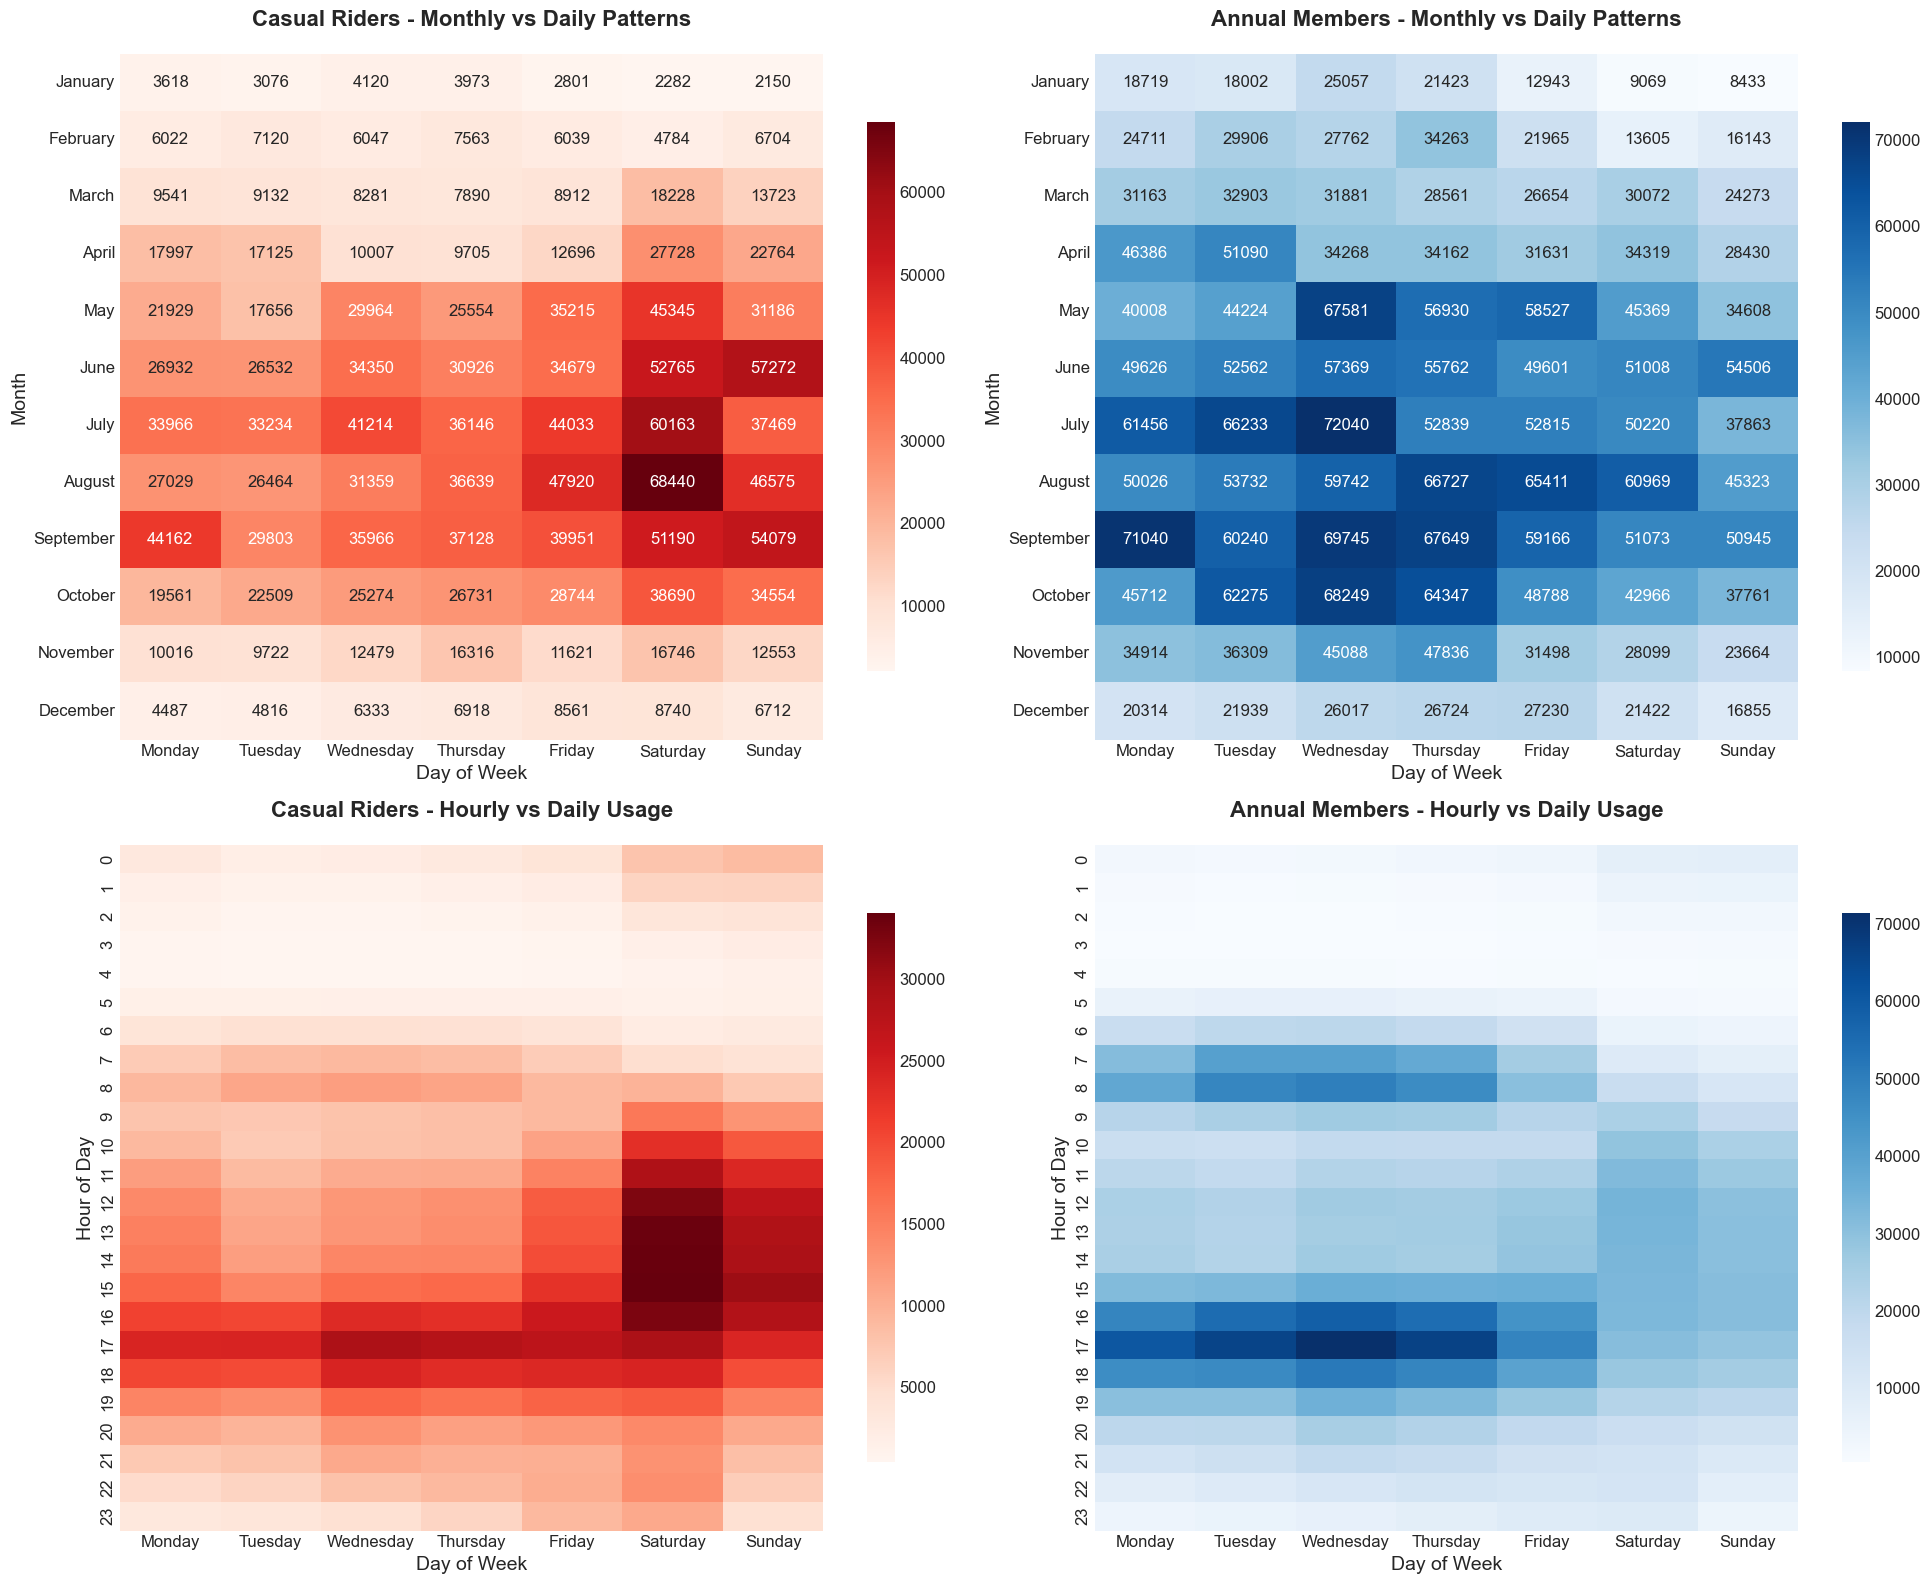

In [78]:
# Create usage intensity heatmap
fig8, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Monthly vs Day of Week heatmap for Casual riders
casual_month_day = df[df['member_casual'] == 'casual'].groupby(['month', 'day_of_week'], observed=False).size().unstack(fill_value=0)
sns.heatmap(casual_month_day, annot=True, fmt='d', cmap='Reds', ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title('Casual Riders - Monthly vs Daily Patterns', fontweight='bold', pad=20)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Month')

# Monthly vs Day of Week heatmap for Members
member_month_day = df[df['member_casual'] == 'member'].groupby(['month', 'day_of_week'], observed=False).size().unstack(fill_value=0)
sns.heatmap(member_month_day, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('Annual Members - Monthly vs Daily Patterns', fontweight='bold', pad=20)
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Month')

# Hour vs Day of Week for Casual riders
casual_hour_day = df[df['member_casual'] == 'casual'].groupby(['hour', 'day_of_week'], observed=False).size().unstack(fill_value=0)
sns.heatmap(casual_hour_day, cmap='Reds', ax=ax3, cbar_kws={'shrink': 0.8})
ax3.set_title('Casual Riders - Hourly vs Daily Usage', fontweight='bold', pad=20)
ax3.set_xlabel('Day of Week')
ax3.set_ylabel('Hour of Day')

# Hour vs Day of Week for Members
member_hour_day = df[df['member_casual'] == 'member'].groupby(['hour', 'day_of_week'], observed=False).size().unstack(fill_value=0)
sns.heatmap(member_hour_day, cmap='Blues', ax=ax4, cbar_kws={'shrink': 0.8})
ax4.set_title('Annual Members - Hourly vs Daily Usage', fontweight='bold', pad=20)
ax4.set_xlabel('Day of Week')
ax4.set_ylabel('Hour of Day')

plt.tight_layout()
plt.show()

### 7. Key Insights Dashboard

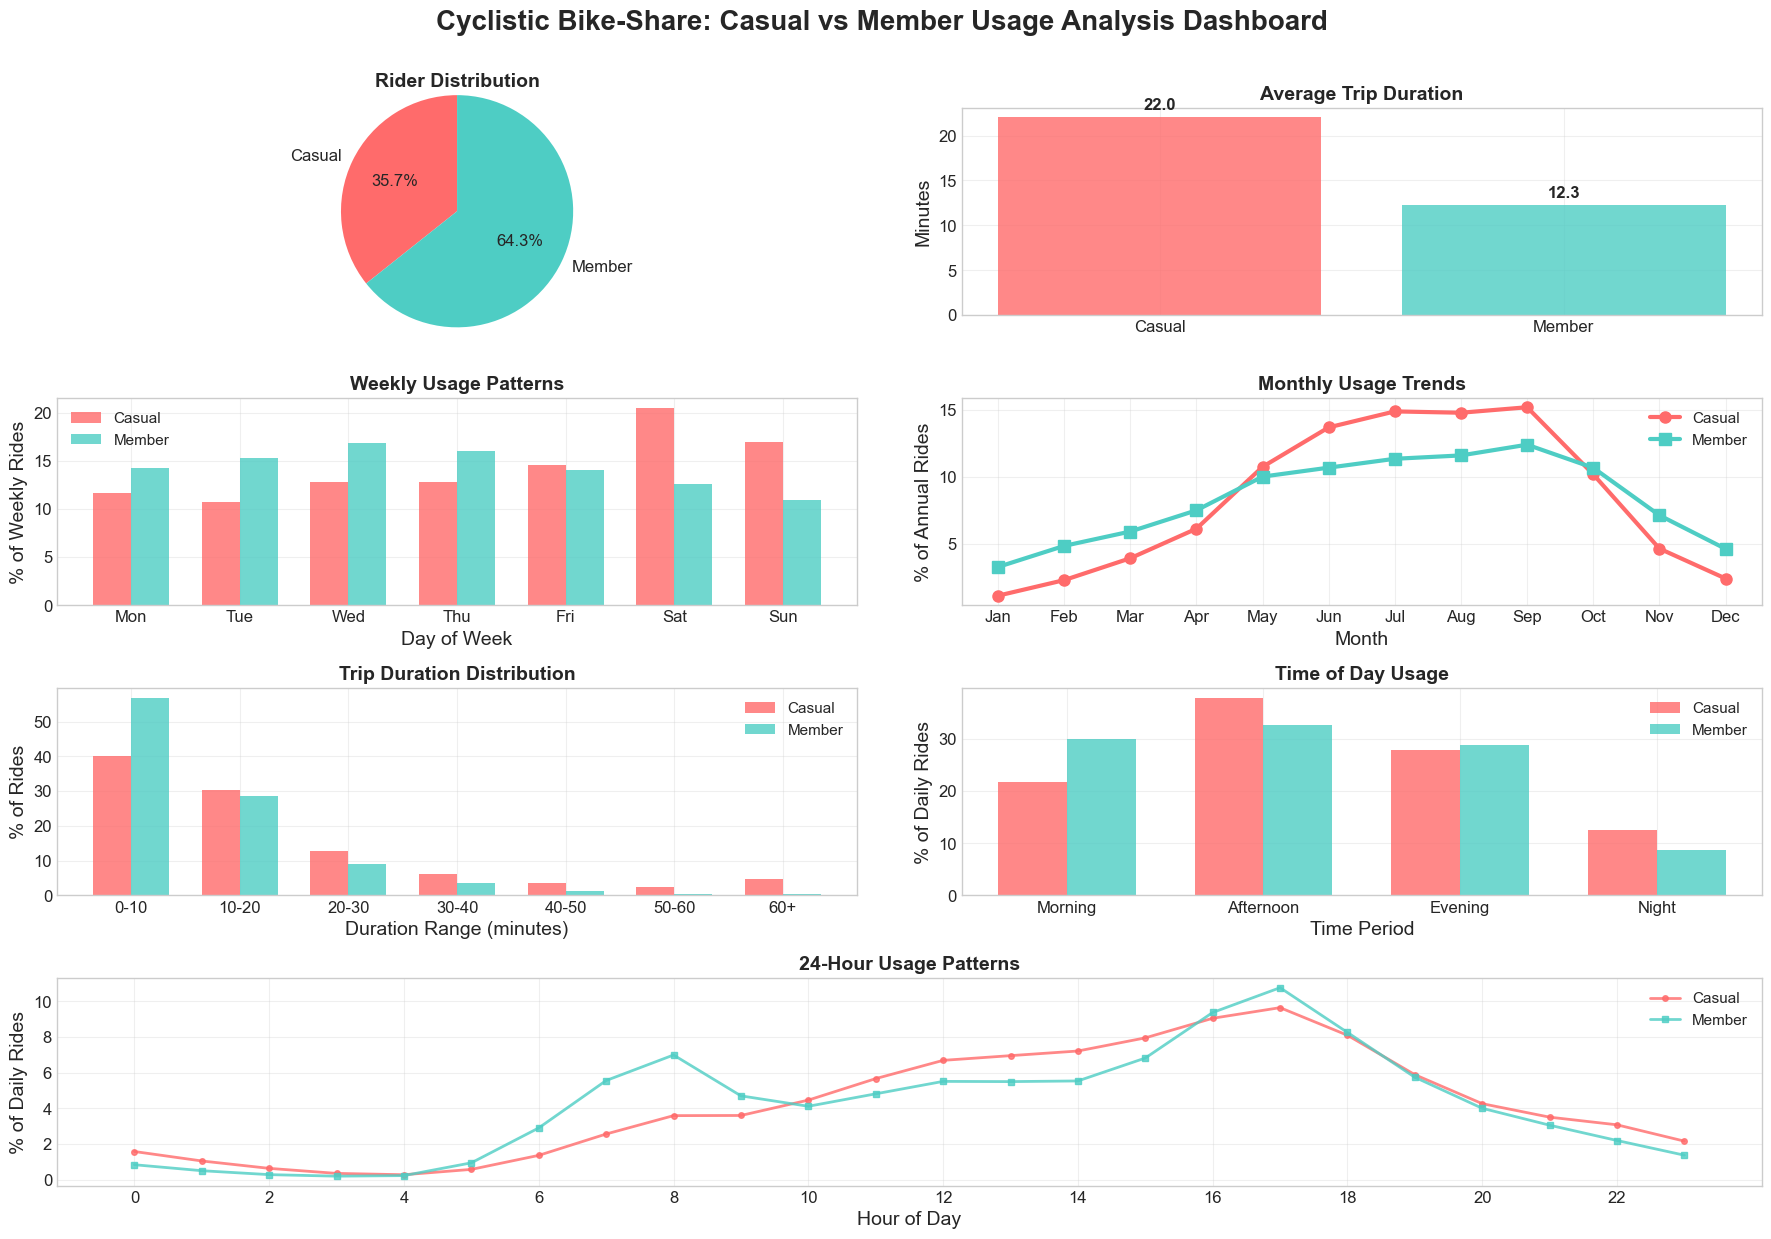

In [83]:
# Create a comprehensive insights dashboard
fig9 = plt.figure(figsize=(22, 14))

# Create a grid layout for the dashboard
gs = fig9.add_gridspec(4, 4, hspace=0.4, wspace=0.3)

# Define colors for consistency
casual_color = '#FF6B6B'
member_color = '#4ECDC4'

# 1. Rider Split (Top Left, spans 2 columns)
ax1 = fig9.add_subplot(gs[0, :2])
sizes = [rider_group_distribution['casual'], rider_group_distribution['member']]
colors = [casual_color, member_color]
# Fix: pie() returns 3 values when autopct is used: wedges, texts, autotexts
wedges, texts, autotexts = ax1.pie(sizes, labels=['Casual', 'Member'], colors=colors, autopct='%1.1f%%', startangle=90, radius=1.4)
ax1.set_title('Rider Distribution', fontweight='bold', fontsize=14, pad=15)

# 2. Average Duration Comparison (Top Right, spans 2 columns)
ax2 = fig9.add_subplot(gs[0, 2:])
avg_durations = [duration_stats.loc['casual', 'mean'], duration_stats.loc['member', 'mean']]
bars = ax2.bar(['Casual', 'Member'], avg_durations, color=[casual_color, member_color], alpha=0.8)
ax2.set_title('Average Trip Duration', fontweight='bold', fontsize=14)
ax2.set_ylabel('Minutes')
for i, v in enumerate(avg_durations):
    ax2.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# 3. Weekly Patterns (Second Row, Spans 2 columns)
ax5 = fig9.add_subplot(gs[1, :2])
x = np.arange(len(daily_pct.columns))
width = 0.35
bars1 = ax5.bar(x - width/2, daily_pct.loc['casual'], width, label='Casual', color=casual_color, alpha=0.8)
bars2 = ax5.bar(x + width/2, daily_pct.loc['member'], width, label='Member', color=member_color, alpha=0.8)
ax5.set_title('Weekly Usage Patterns', fontweight='bold', fontsize=14)
ax5.set_xlabel('Day of Week')
ax5.set_ylabel('% of Weekly Rides')
ax5.set_xticks(x)
ax5.set_xticklabels([day[:3] for day in daily_pct.columns])
ax5.legend()

# 4. Monthly Trends (Second Row, Right 2 columns)
ax6 = fig9.add_subplot(gs[1, 2:])
months_short = [month[:3] for month in monthly_pct.columns]
ax6.plot(months_short, monthly_pct.loc['casual'], marker='o', linewidth=3, 
         markersize=8, label='Casual', color=casual_color)
ax6.plot(months_short, monthly_pct.loc['member'], marker='s', linewidth=3, 
         markersize=8, label='Member', color=member_color)
ax6.set_title('Monthly Usage Trends', fontweight='bold', fontsize=14)
ax6.set_xlabel('Month')
ax6.set_ylabel('% of Annual Rides')
ax6.tick_params(axis='x')
ax6.legend()

# 5. Duration Distribution (Third Row, Left 2 columns)
ax7 = fig9.add_subplot(gs[2, :2])
duration_ranges = trip_duration_dist_pct.columns
x = np.arange(len(duration_ranges))
width = 0.35
bars1 = ax7.bar(x - width/2, trip_duration_dist_pct.loc['casual'], width, 
                label='Casual', color=casual_color, alpha=0.8)
bars2 = ax7.bar(x + width/2, trip_duration_dist_pct.loc['member'], width,
                label='Member', color=member_color, alpha=0.8)
ax7.set_title('Trip Duration Distribution', fontweight='bold', fontsize=14)
ax7.set_xlabel('Duration Range (minutes)')
ax7.set_ylabel('% of Rides')
ax7.set_xticks(x)
ax7.set_xticklabels(duration_ranges)
ax7.legend()

# 6. Time of Day Usage (Third Row, Right 2 columns)
ax8 = fig9.add_subplot(gs[2, 2:])
period_order = ['Morning', 'Afternoon', 'Evening', 'Night']
hourly_pct_ordered = hourly_pct.reindex(columns=period_order)
x = np.arange(len(period_order))
width = 0.35
bars1 = ax8.bar(x - width/2, hourly_pct_ordered.loc['casual'], width, 
                label='Casual', color=casual_color, alpha=0.8)
bars2 = ax8.bar(x + width/2, hourly_pct_ordered.loc['member'], width,
                label='Member', color=member_color, alpha=0.8)
ax8.set_title('Time of Day Usage', fontweight='bold', fontsize=14)
ax8.set_xlabel('Time Period')
ax8.set_ylabel('% of Daily Rides')
ax8.set_xticks(x)
ax8.set_xticklabels(period_order)
ax8.legend()

# 7. Hourly Usage Pattern (Bottom Row)
ax9 = fig9.add_subplot(gs[3, :])
hours = list(range(24))

# Get hourly distribution as percentages
casual_hourly_counts = df[df['member_casual'] == 'casual']['hour'].value_counts().sort_index()
member_hourly_counts = df[df['member_casual'] == 'member']['hour'].value_counts().sort_index()

# Convert to percentages
casual_hourly = (casual_hourly_counts / casual_hourly_counts.sum() * 100).values
member_hourly = (member_hourly_counts / member_hourly_counts.sum() * 100).values

ax9.plot(hours, casual_hourly, marker='o', linewidth=2, markersize=4, 
         label='Casual', color=casual_color, alpha=0.8)
ax9.plot(hours, member_hourly, marker='s', linewidth=2, markersize=4,
         label='Member', color=member_color, alpha=0.8)
ax9.set_title('24-Hour Usage Patterns', fontweight='bold', fontsize=14)
ax9.set_xlabel('Hour of Day')
ax9.set_ylabel('% of Daily Rides')
ax9.set_xticks(range(0, 24, 2))
ax9.legend()
ax9.grid(True, alpha=0.3)

# Add main title
fig9.suptitle('Cyclistic Bike-Share: Casual vs Member Usage Analysis Dashboard', 
              fontsize=20, fontweight='bold', y=0.95)

plt.savefig('cyclistic_dashboard.png', dpi=400, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

## Conclusion

### Strategic Recommendations for Membership Conversion

#### Immediate Actions
1. Target casual riders during weekday commute hours (8-9 AM, 5-6 PM)
2. Offer trial memberships during peak casual usage months (June-August)
3. Focus marketing at high-traffic casual stations near business districts

#### Pricing Strategies
1. Introduce weekend-only membership tiers for leisure riders
2. Offer seasonal memberships aligned with casual usage patterns
3. Create duration-based pricing incentives for longer rides

#### Marketing Insights
1. Emphasize convenience and cost savings for regular commuters
2. Highlight health and environmental benefits during peak casual months
3. Use location-based targeting near popular casual rider stations

#### Product Development
1. Develop commuter-focused features and rewards
2. Create weekend/leisure rider engagement programs
3. Implement referral programs targeting existing members

## Appendix

### Data Quality and Limitations

In [80]:
# Document data quality metrics
data_quality_summary = {
    "Original Records": f"{integration_stats['total_records']:,}",
    "Final Dataset": f"{len(df):,}",
    "Data Retention": f"{(len(df) / integration_stats['total_records']) * 100:.1f}%",
    "Issues Resolved": [
        f"Duplicate ride IDs: 422 records (0.01%)",
        f"Missing station data: 531,150 records (9.58%)",  
        f"Invalid timestamps: 160 records (<0.01%)",
        f"Invalid durations: 8,109 records (0.15%)"
    ],
    "Limitations": [
        "Geographic analysis limited by missing station data",
        "Some ride purposes inferred from patterns, not directly measured",
        "Seasonal patterns may vary year-to-year",
        "External factors (weather, events) not accounted for"
    ]
}

print("DATA QUALITY ASSESSMENT")
print("="*40)
print()
print(f"Original Records: {data_quality_summary['Original Records']}")
print(f"Final Dataset: {data_quality_summary['Final Dataset']}")
print(f"Data Retention: {data_quality_summary['Data Retention']}")
print()
print("ISSUES RESOLVED:")
for issue in data_quality_summary['Issues Resolved']:
    print(f"• {issue}")
print()
print("LIMITATIONS:")
for limitation in data_quality_summary['Limitations']:
    print(f"• {limitation}")

print("\nAnalysis completed successfully! 🚴‍♀️📊")

DATA QUALITY ASSESSMENT

Original Records: 5,933,712
Final Dataset: 5,394,082
Data Retention: 90.9%

ISSUES RESOLVED:
• Duplicate ride IDs: 422 records (0.01%)
• Missing station data: 531,150 records (9.58%)
• Invalid timestamps: 160 records (<0.01%)
• Invalid durations: 8,109 records (0.15%)

LIMITATIONS:
• Geographic analysis limited by missing station data
• Some ride purposes inferred from patterns, not directly measured
• Seasonal patterns may vary year-to-year
• External factors (weather, events) not accounted for

Analysis completed successfully! 🚴‍♀️📊
